In [1]:
import tensorflow as tf
import tensorflow.keras
import numpy as np
import pandas as pd
import pickle


from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, LSTM, TimeDistributed, InputLayer, Reshape, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


2022-12-16 20:09:06.265526: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Load data

0: no normalization technique<br>1: sum of each matrix cell equal 1<br>2: each cell in matrix is divided by the maximum value of the matrix<br>3: MinMax scaler to each sample's matrix

In [2]:
def load_data(dsname):
    metadata = pd.read_csv("/datasets/nicolas_facchinetti/processed_data/emodb/metadata_final.csv")
    data0 = pickle.load(open("/datasets/nicolas_facchinetti/processed_data/emodb/processed_data0.p", "rb" ))
    data1 = pickle.load(open("/datasets/nicolas_facchinetti/processed_data/emodb/processed_data1.p", "rb" ))
    data2 = pickle.load(open("/datasets/nicolas_facchinetti/processed_data/emodb/processed_data2.p", "rb" ))
    data3 = pickle.load(open("/datasets/nicolas_facchinetti/processed_data/emodb/processed_data3.p", "rb" ))
    y = pickle.load(open("/datasets/nicolas_facchinetti/processed_data/emodb/processed_labels.p", "rb" ))
    return metadata, data0, data1, data2, data3, y

Function to standardize input features

In [3]:
from sklearn.preprocessing import StandardScaler
def standardize(data):
    scaler = StandardScaler()
    n = data.shape
    return scaler.fit_transform(data.reshape(n[0],-1)).reshape(n)

Plot reults

In [4]:
import matplotlib.pyplot as plt
from collections.abc import Iterable

def plot_res_acc(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_res_loss(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_stats(h):
    fig = plt.gcf()
    fig.set_size_inches(15, 15)
    for num, c in enumerate(h):
        n = (num+1)*2
        plot_res_acc(c, len(h), n-1)
        plot_res_loss(c, len(h), n)
    plt.show()
    
def get_results(h):
    test = [s[1] for s in h]
    plot = [s[0] for s in h]

    print(f'Test set results:{test}\nAverage loss:{np.average([s[0] for s in test])}\nAverage accuracy:{np.average([s[1] for s in test])}') 

    plot_stats(plot)

# Model definition

In [5]:
def train_evaluate(model_fn, train, val, test, opt='adam'):
    m = model_fn()
    m.compile(loss='categorical_crossentropy', optimizer=opt, metrics='accuracy')
    
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1, min_delta=1e-4, mode='min')

    # fit & predict
    history = m.fit(train[0], train[1],
                    epochs=50,
                    batch_size=32,
                    callbacks=[earlyStopping, reduce_lr_loss],
                    validation_data=(val[0], val[1]),
                    verbose=1)
    print("Done")
    # test
    print("Evaluate on test data")
    results = m.evaluate(test[0], test[1], batch_size=32)
    print("test loss, test acc:", results)
    return history, results

In [6]:
from sklearn.model_selection import train_test_split

def train_kfold(model_fn, x, y, metadata, n=[1997,1941,1965]):    
    results = []
    
    train_df, test_df = train_test_split(metadata, 
                                   test_size = 0.1, 
                                   random_state = 2022,
                                   stratify = metadata['label'])
    test_index = test_df.index
    x_test = x[test_index]
    y_test = y[test_index]
    for rs in n:
        trainK_df, val_df = train_test_split(train_df, 
                                   test_size = 0.15, 
                                   random_state = rs,
                                   stratify = train_df['label'])
        train_index = trainK_df.index
        val_index = val_df.index
        x_train = x[train_index]
        y_train = y[train_index]
        x_val = x[val_index]
        y_val = y[val_index]
        
        results.append(train_evaluate(model_fn, (x_train, y_train), (x_val, y_val), (x_test, y_test)))
    return results

In [7]:
def get_m():
    m = Sequential([
            InputLayer(input_shape=(261,128,1)),
            Reshape((9,29,128,1)),
            TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(4,4), strides=2)),

            TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),
            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),
            
            LSTM(3, return_sequences=False, dropout=0.2),
            Dense(5, activation='softmax')
    ])
    return m

get_m().summary()

2022-12-16 20:09:08.038096: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-16 20:09:08.038990: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-16 20:09:08.173804: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:15:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 607.97GiB/s
2022-12-16 20:09:08.173833: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-16 20:09:08.175709: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-16 20:09:08.175792: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 9, 29, 128, 1)     0         
_________________________________________________________________
time_distributed (TimeDistri (None, 9, 25, 124, 16)    416       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 9, 25, 124, 16)    64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 9, 11, 61, 16)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 9, 9, 59, 32)      4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 9, 4, 29, 32)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 9, 2, 27, 64)      1

In [8]:
def experiments(metadata, data, y, get_m):
    res = []
    for d in data:
        r = train_kfold(get_m, d, y, metadata)
        get_results(r)
        res.append(r)
    return res

# EMODB

In [9]:
metadata, data0, data1, data2, data3, y = load_data('emodb')
metadata

path     filename  chunk  \
0     /datasets/nicolas_facchinetti/emodb/data/14b09...  14b09Ac.wav      0   
1     /datasets/nicolas_facchinetti/emodb/data/14b09...  14b09Ac.wav      0   
2     /datasets/nicolas_facchinetti/emodb/data/14b09...  14b09Ac.wav      0   
3     /datasets/nicolas_facchinetti/emodb/data/14b09...  14b09Ac.wav      0   
4     /datasets/nicolas_facchinetti/emodb/data/14b09...  14b09Ac.wav      0   
...                                                 ...          ...    ...   
3740  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      0   
3741  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      1   
3742  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      0   
3743  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      0   
3744  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      0   

      label  actor gender  mod  
0      fear     14      f    0  
1      fear     14      f    1  
2      fear     14      f    1  
3      fear     14      f    1  
4      fear     14      f    1  
...     ...    ...    ...  ...  
3740  happy      8      f    2  
3741  happy      8      f    2  
3742  happy      8      f    2  
3743  happy      8      f    2  
3744  happy      8      f    2  

[3745 rows x 7 columns]

In [10]:
data0.shape, data1.shape, data2.shape, data3.shape, y.shape,

((3745, 261, 128, 1),
 (3745, 261, 128, 1),
 (3745, 261, 128, 1),
 (3745, 261, 128, 1),
 (3745, 5))

## Without standardization

2022-12-16 20:09:10.520747: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-16 20:09:10.535394: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3301490000 Hz


Epoch 1/50


2022-12-16 20:09:11.552820: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-16 20:09:11.736892: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


90/90 [==============================] - 5s 22ms/step - loss: 1.5178 - accuracy: 0.3174 - val_loss: 1.4242 - val_accuracy: 0.4051
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4056 - accuracy: 0.3998 - val_loss: 1.2536 - val_accuracy: 0.5217
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3441 - accuracy: 0.4391 - val_loss: 1.2340 - val_accuracy: 0.5138
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2808 - accuracy: 0.4698 - val_loss: 1.2572 - val_accuracy: 0.4822
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1952 - accuracy: 0.5192 - val_loss: 1.1350 - val_accuracy: 0.5692
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1658 - accuracy: 0.5295 - val_loss: 1.1942 - val_accuracy: 0.5079
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1144 - accuracy: 0.5609 - val_loss: 1.1474 - val_accuracy: 0.5593
Epoch 8/50
90/90 [======

90/90 [==============================] - 1s 15ms/step - loss: 1.4057 - accuracy: 0.4454 - val_loss: 1.3910 - val_accuracy: 0.4526
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3877 - accuracy: 0.4525 - val_loss: 1.3498 - val_accuracy: 0.4625
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3567 - accuracy: 0.4738 - val_loss: 1.3213 - val_accuracy: 0.4921
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3299 - accuracy: 0.4792 - val_loss: 1.7178 - val_accuracy: 0.2470
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3377 - accuracy: 0.4656 - val_loss: 1.3039 - val_accuracy: 0.4802
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2908 - accuracy: 0.4793 - val_loss: 1.3554 - val_accuracy: 0.4249
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2796 - accuracy: 0.4870 - val_loss: 1.3352 - val_accuracy: 0.4802
Epoch 13/50
90/90 [==

90/90 [==============================] - 1s 15ms/step - loss: 1.3039 - accuracy: 0.4666 - val_loss: 1.2968 - val_accuracy: 0.4585
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2873 - accuracy: 0.4606 - val_loss: 1.4008 - val_accuracy: 0.3953
Epoch 14/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2925 - accuracy: 0.4479 - val_loss: 1.3003 - val_accuracy: 0.4368
Epoch 15/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2494 - accuracy: 0.4744 - val_loss: 1.7899 - val_accuracy: 0.3281
Epoch 16/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2420 - accuracy: 0.4791 - val_loss: 1.4112 - val_accuracy: 0.3933
Epoch 17/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2628 - accuracy: 0.4748 - val_loss: 1.3037 - val_accuracy: 0.4269
Epoch 18/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1951 - accuracy: 0.5024 - val_loss: 1.2869 - val_accuracy: 0.4506
Epoch 19/50
90/90 

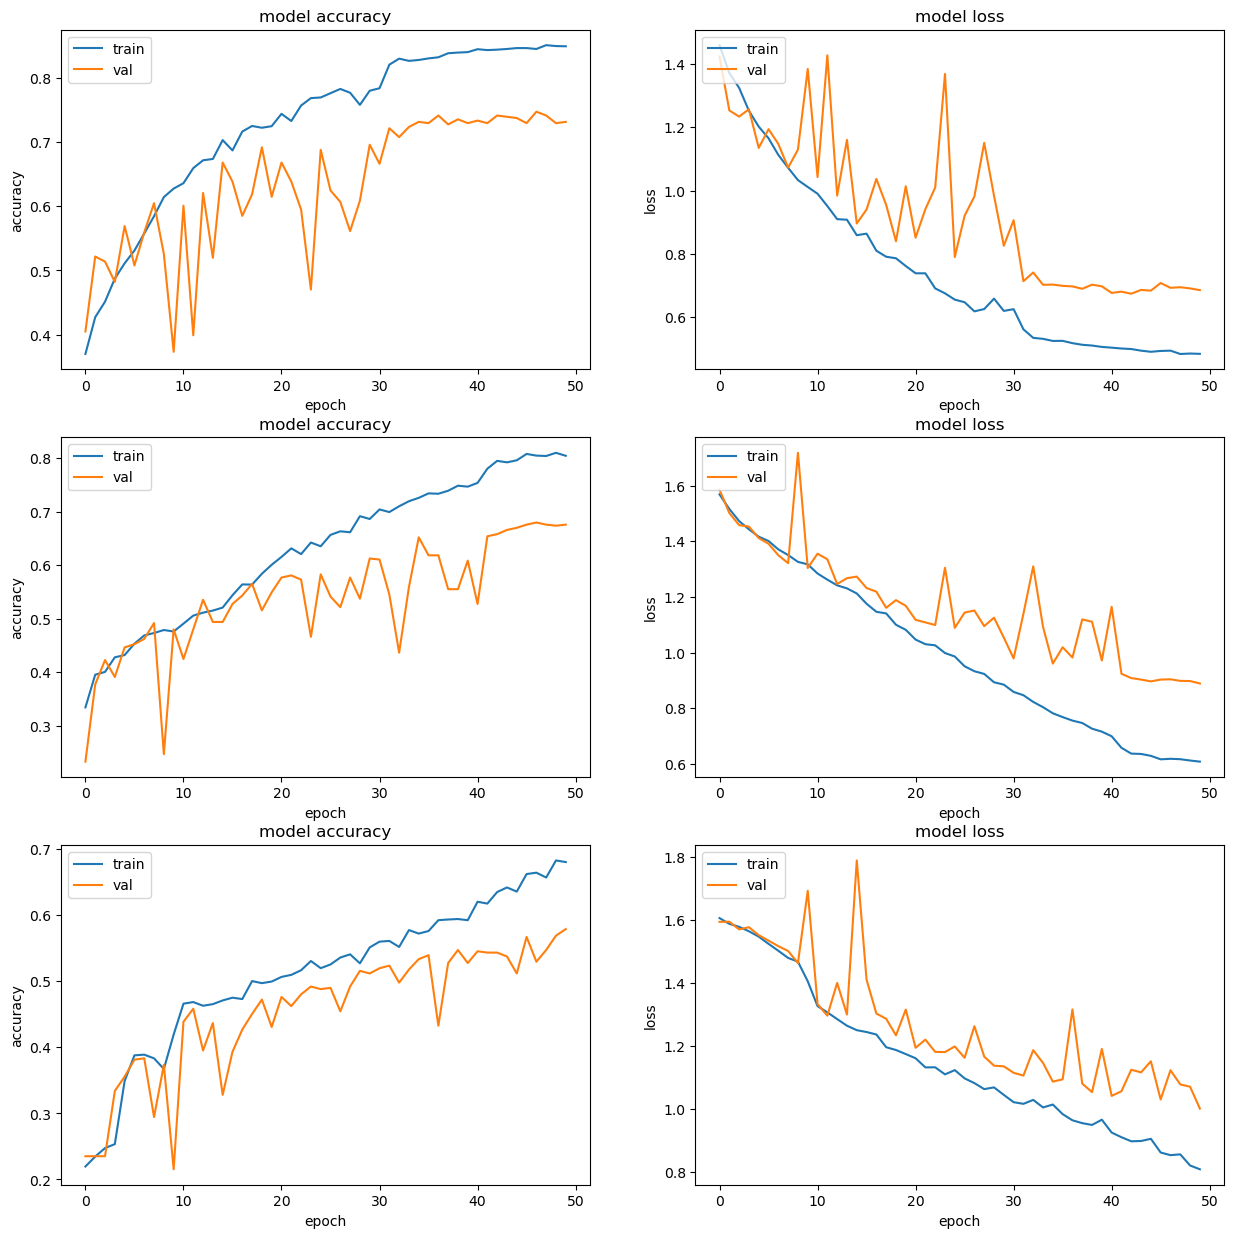

Epoch 1/50
90/90 [==============================] - 3s 19ms/step - loss: 1.6089 - accuracy: 0.2283 - val_loss: 1.6045 - val_accuracy: 0.2352
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6046 - accuracy: 0.2413 - val_loss: 1.6031 - val_accuracy: 0.2352
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6029 - accuracy: 0.2373 - val_loss: 1.6023 - val_accuracy: 0.2352
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6039 - accuracy: 0.2391 - val_loss: 1.6025 - val_accuracy: 0.2352
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6012 - accuracy: 0.2282 - val_loss: 1.6077 - val_accuracy: 0.2352
Epoch 6/50
90/90 [==============================] - 1s 14ms/step - loss: 1.5924 - accuracy: 0.2607 - val_loss: 1.7944 - val_accuracy: 0.2352
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4447 - accuracy: 0.3889 - val_loss: 1.9404 - val_accuracy: 0.2352
Epoch 8/50
90

90/90 [==============================] - 1s 15ms/step - loss: 1.0677 - accuracy: 0.5756 - val_loss: 1.0794 - val_accuracy: 0.5731
Epoch 35/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0739 - accuracy: 0.5702 - val_loss: 1.0735 - val_accuracy: 0.5692
Epoch 36/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0461 - accuracy: 0.5847 - val_loss: 1.0808 - val_accuracy: 0.5731
Epoch 37/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0651 - accuracy: 0.5725 - val_loss: 1.0717 - val_accuracy: 0.5692
Epoch 38/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0503 - accuracy: 0.5750 - val_loss: 1.0730 - val_accuracy: 0.5652
Epoch 39/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0346 - accuracy: 0.5860 - val_loss: 1.0827 - val_accuracy: 0.5771
Epoch 40/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0527 - accuracy: 0.5733 - val_loss: 1.0794 - val_accuracy: 0.5751
Epoch 41/50
90/90 

90/90 [==============================] - 1s 15ms/step - loss: 1.0417 - accuracy: 0.5848 - val_loss: 1.1155 - val_accuracy: 0.5692
Epoch 41/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0072 - accuracy: 0.5967 - val_loss: 1.0809 - val_accuracy: 0.5652
Epoch 42/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9868 - accuracy: 0.6085 - val_loss: 1.4791 - val_accuracy: 0.4190
Epoch 43/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9959 - accuracy: 0.6186 - val_loss: 1.1416 - val_accuracy: 0.5514
Epoch 44/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9894 - accuracy: 0.6052 - val_loss: 1.0636 - val_accuracy: 0.5870

Epoch 00044: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 45/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0089 - accuracy: 0.6048 - val_loss: 1.0444 - val_accuracy: 0.5870
Epoch 46/50
90/90 [==============================] - 1s 15ms/step - loss: 1.00

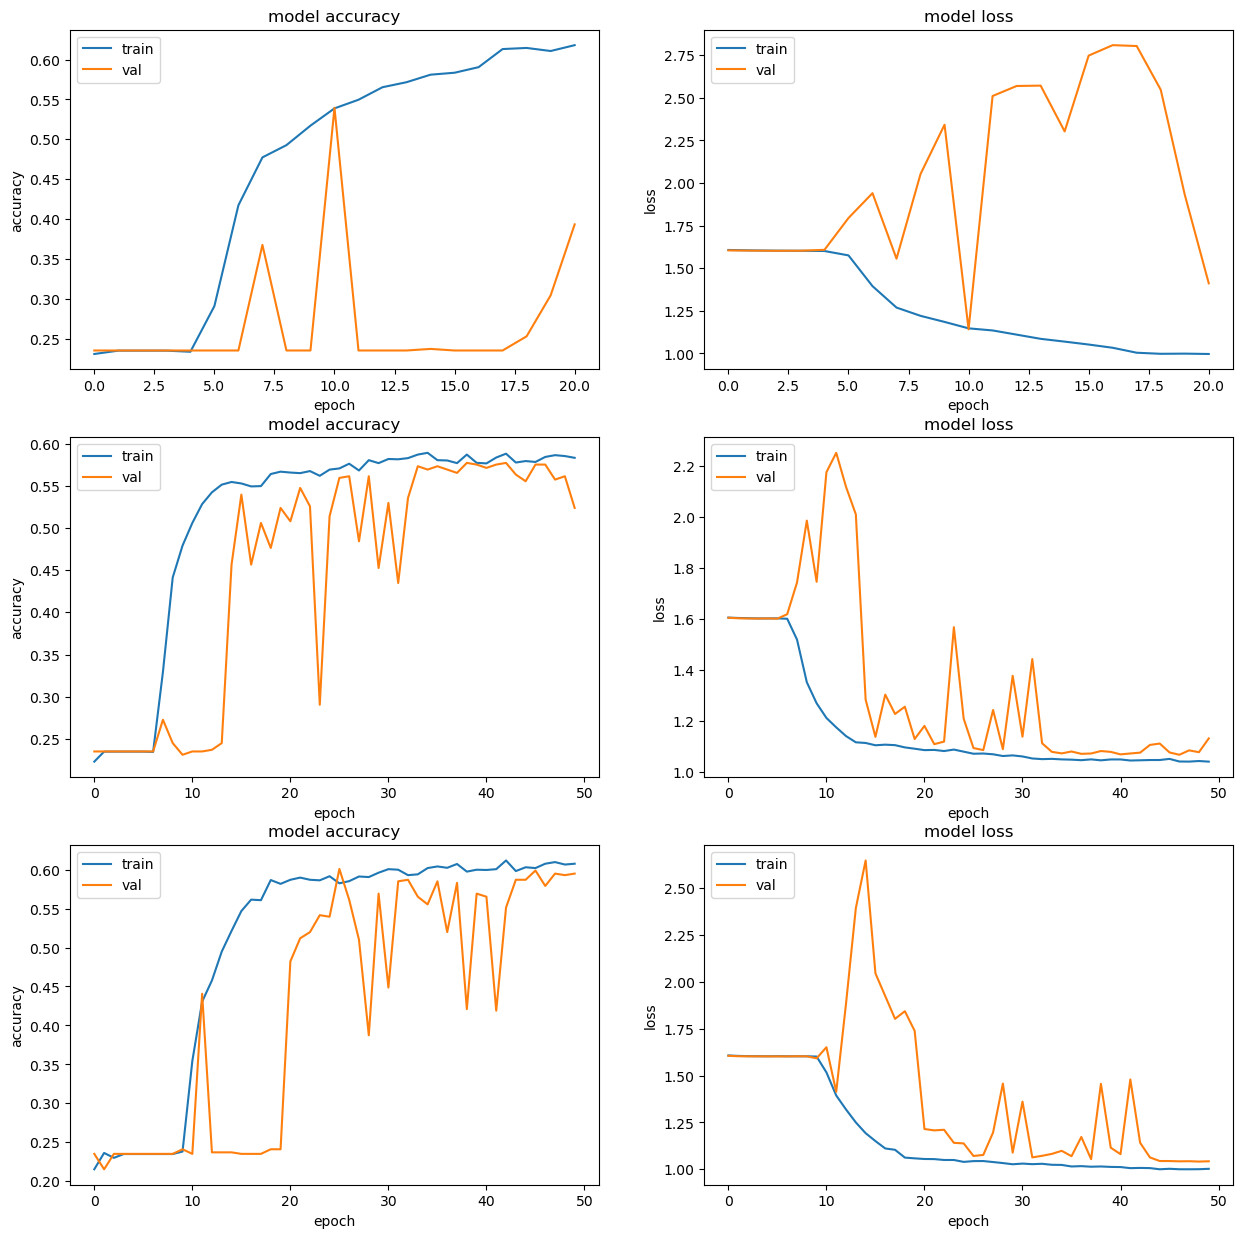

Epoch 1/50
90/90 [==============================] - 3s 19ms/step - loss: 1.6062 - accuracy: 0.2317 - val_loss: 1.5930 - val_accuracy: 0.2490
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5551 - accuracy: 0.3391 - val_loss: 1.5507 - val_accuracy: 0.3854
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5017 - accuracy: 0.3982 - val_loss: 1.5337 - val_accuracy: 0.3379
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4601 - accuracy: 0.4266 - val_loss: 1.4667 - val_accuracy: 0.4427
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4303 - accuracy: 0.4300 - val_loss: 1.3870 - val_accuracy: 0.4466
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4181 - accuracy: 0.4205 - val_loss: 1.3552 - val_accuracy: 0.4506
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3484 - accuracy: 0.4642 - val_loss: 1.4185 - val_accuracy: 0.4348
Epoch 8/50
90

Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0557 - accuracy: 0.5966 - val_loss: 1.0413 - val_accuracy: 0.6285
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9777 - accuracy: 0.6407 - val_loss: 1.2292 - val_accuracy: 0.5336
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9404 - accuracy: 0.6681 - val_loss: 1.2674 - val_accuracy: 0.4941
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9361 - accuracy: 0.6542 - val_loss: 1.2259 - val_accuracy: 0.5277
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9015 - accuracy: 0.6852 - val_loss: 1.4358 - val_accuracy: 0.4506
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8483 - accuracy: 0.7107 - val_loss: 1.4802 - val_accuracy: 0.4328
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8263 - accuracy: 0.7208 - val_loss: 1.0261 - val_accuracy: 0.6107
Epoch 14/

Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9275 - accuracy: 0.6943 - val_loss: 1.1102 - val_accuracy: 0.5751
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8967 - accuracy: 0.6994 - val_loss: 1.1907 - val_accuracy: 0.5435
Epoch 14/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8361 - accuracy: 0.7221 - val_loss: 1.1861 - val_accuracy: 0.5178
Epoch 15/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8179 - accuracy: 0.7286 - val_loss: 1.1995 - val_accuracy: 0.5632
Epoch 16/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8031 - accuracy: 0.7343 - val_loss: 1.2511 - val_accuracy: 0.5000
Epoch 17/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8135 - accuracy: 0.7414 - val_loss: 0.8981 - val_accuracy: 0.6640
Epoch 18/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7272 - accuracy: 0.7641 - val_loss: 1.1297 - val_accuracy: 0.5652
Epoch 

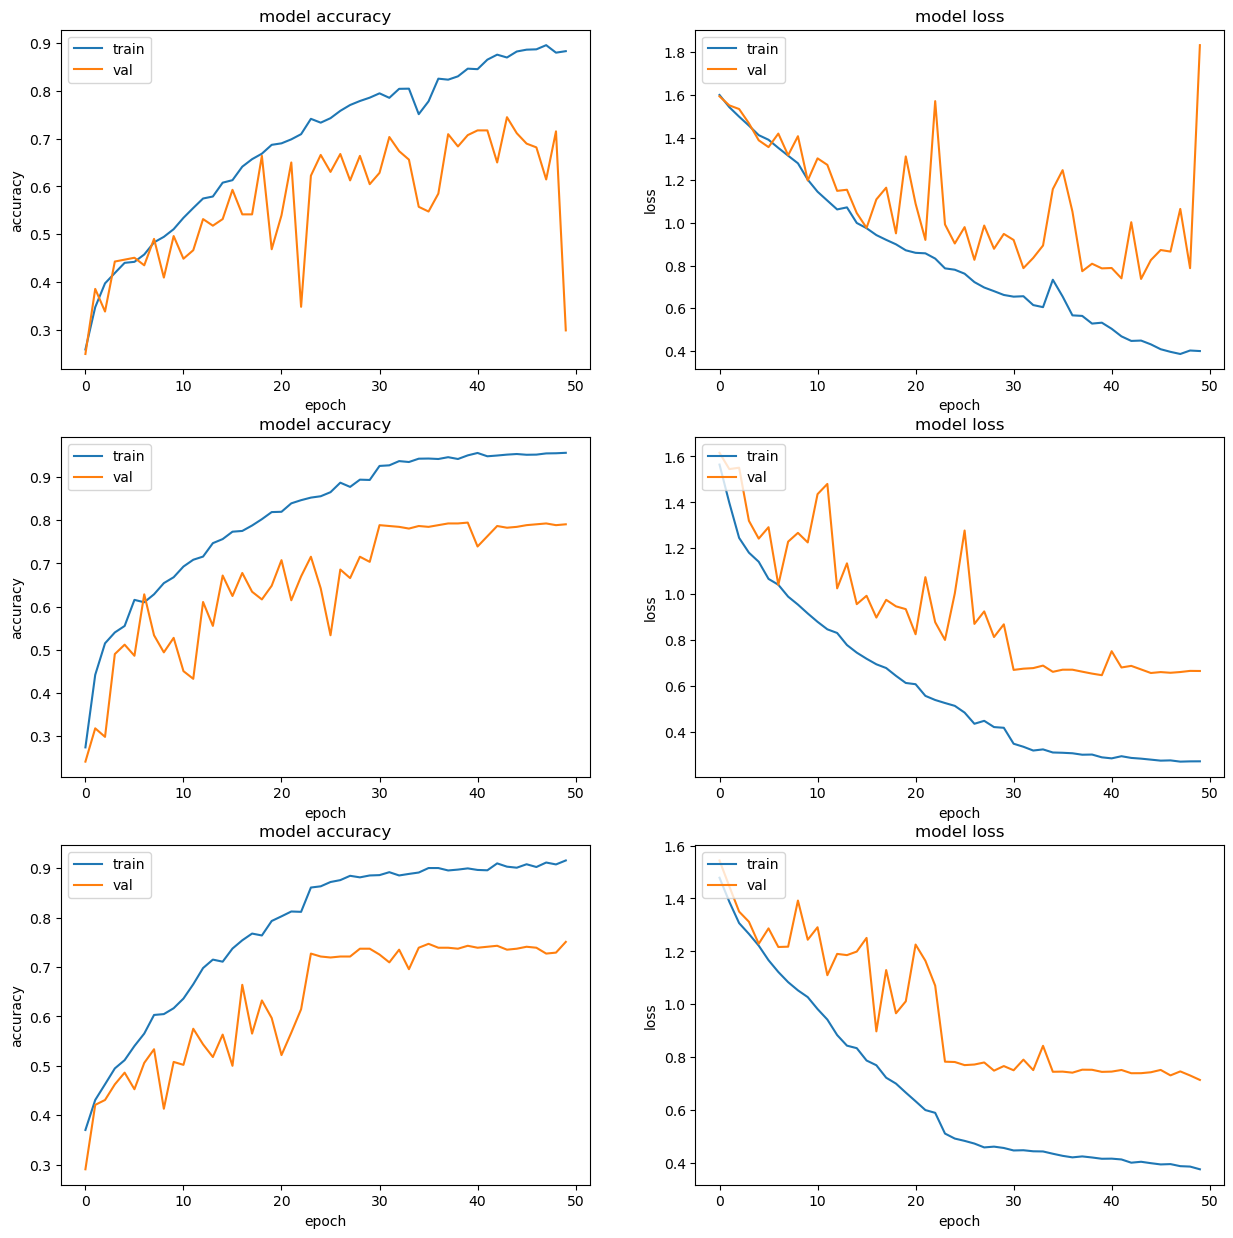

Epoch 1/50
90/90 [==============================] - 3s 18ms/step - loss: 1.5966 - accuracy: 0.2572 - val_loss: 1.5319 - val_accuracy: 0.3656
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4462 - accuracy: 0.4040 - val_loss: 1.4467 - val_accuracy: 0.4269
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4097 - accuracy: 0.4201 - val_loss: 1.3721 - val_accuracy: 0.4605
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2750 - accuracy: 0.5184 - val_loss: 1.3845 - val_accuracy: 0.3854
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2077 - accuracy: 0.5500 - val_loss: 1.2649 - val_accuracy: 0.5099
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1185 - accuracy: 0.5906 - val_loss: 1.2554 - val_accuracy: 0.5237
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0630 - accuracy: 0.6146 - val_loss: 1.1151 - val_accuracy: 0.5771
Epoch 8/50
90

90/90 [==============================] - 1s 15ms/step - loss: 1.4461 - accuracy: 0.4165 - val_loss: 1.4147 - val_accuracy: 0.4348
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3939 - accuracy: 0.4520 - val_loss: 1.4241 - val_accuracy: 0.4170
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3769 - accuracy: 0.4391 - val_loss: 1.3930 - val_accuracy: 0.4387
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3133 - accuracy: 0.4664 - val_loss: 1.2679 - val_accuracy: 0.4763
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2216 - accuracy: 0.4964 - val_loss: 1.2287 - val_accuracy: 0.4822
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1339 - accuracy: 0.5318 - val_loss: 1.1618 - val_accuracy: 0.5158
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0795 - accuracy: 0.5591 - val_loss: 1.1298 - val_accuracy: 0.5474
Epoch 13/50
90/90 [==

90/90 [==============================] - 1s 15ms/step - loss: 0.9350 - accuracy: 0.6624 - val_loss: 0.9872 - val_accuracy: 0.6067
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8764 - accuracy: 0.6655 - val_loss: 0.9615 - val_accuracy: 0.6186
Epoch 14/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8387 - accuracy: 0.6911 - val_loss: 0.9484 - val_accuracy: 0.6186
Epoch 15/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7937 - accuracy: 0.7346 - val_loss: 0.9555 - val_accuracy: 0.6126
Epoch 16/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7413 - accuracy: 0.7527 - val_loss: 0.9352 - val_accuracy: 0.6403
Epoch 17/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7077 - accuracy: 0.7732 - val_loss: 0.9062 - val_accuracy: 0.6462
Epoch 18/50
90/90 [==============================] - 1s 15ms/step - loss: 0.6761 - accuracy: 0.7844 - val_loss: 0.8678 - val_accuracy: 0.6838
Epoch 19/50
90/90 

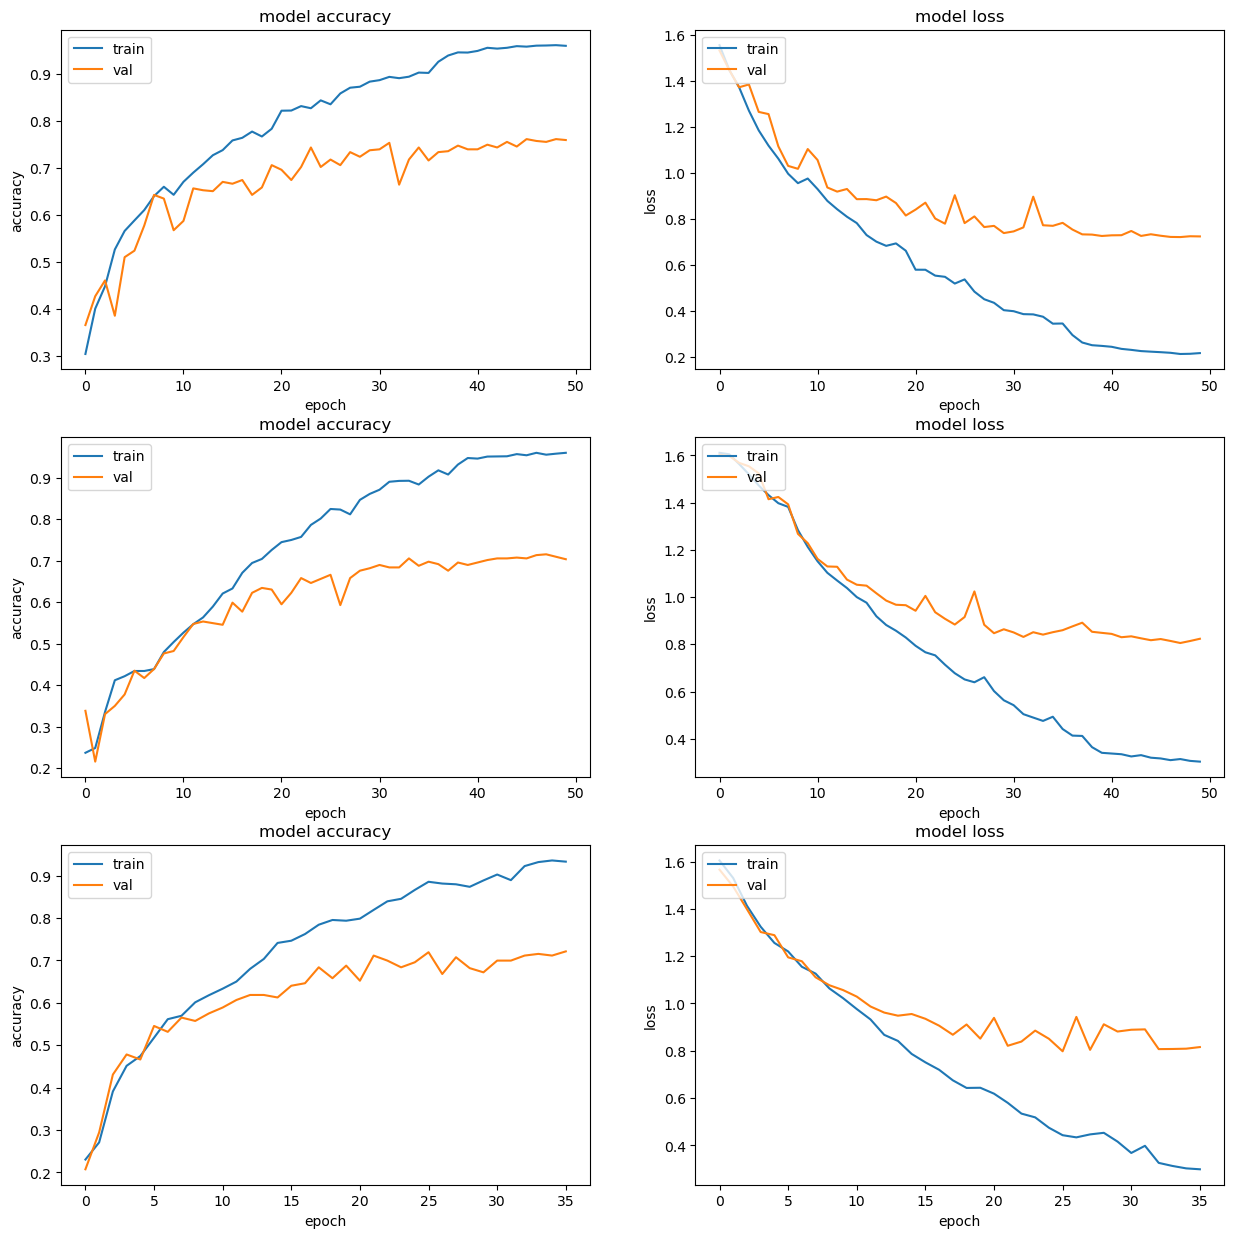

In [11]:
emodb1 = experiments(metadata, [data0, data1, data2, data3], y, get_m)

## With standardization

In [12]:
data0s = standardize(data0)
data1s = standardize(data1)
data2s = standardize(data2)
data3s = standardize(data3)

Epoch 1/50
90/90 [==============================] - 3s 18ms/step - loss: 1.6160 - accuracy: 0.2324 - val_loss: 1.6071 - val_accuracy: 0.2332
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6058 - accuracy: 0.2295 - val_loss: 1.6016 - val_accuracy: 0.2352
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6000 - accuracy: 0.2415 - val_loss: 1.5972 - val_accuracy: 0.2411
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5987 - accuracy: 0.2347 - val_loss: 1.5811 - val_accuracy: 0.2134
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5887 - accuracy: 0.2130 - val_loss: 1.5081 - val_accuracy: 0.2095
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5468 - accuracy: 0.2830 - val_loss: 1.4353 - val_accuracy: 0.3577
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4208 - accuracy: 0.3611 - val_loss: 1.3656 - val_accuracy: 0.4605
Epoch 8/50
90

90/90 [==============================] - 1s 15ms/step - loss: 1.2609 - accuracy: 0.4837 - val_loss: 1.2479 - val_accuracy: 0.4802
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2108 - accuracy: 0.5122 - val_loss: 1.2456 - val_accuracy: 0.4980
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2150 - accuracy: 0.5106 - val_loss: 1.2159 - val_accuracy: 0.5119
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1800 - accuracy: 0.5352 - val_loss: 1.1802 - val_accuracy: 0.5534
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1700 - accuracy: 0.5346 - val_loss: 1.1804 - val_accuracy: 0.5316
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1362 - accuracy: 0.5505 - val_loss: 1.1634 - val_accuracy: 0.5336
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1092 - accuracy: 0.5767 - val_loss: 1.1579 - val_accuracy: 0.5296
Epoch 14/50
90/90 [=

90/90 [==============================] - 1s 15ms/step - loss: 1.0419 - accuracy: 0.6306 - val_loss: 1.1021 - val_accuracy: 0.5672
Epoch 14/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0403 - accuracy: 0.6259 - val_loss: 1.0816 - val_accuracy: 0.5929
Epoch 15/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0126 - accuracy: 0.6434 - val_loss: 1.0637 - val_accuracy: 0.6047
Epoch 16/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9742 - accuracy: 0.6592 - val_loss: 1.0629 - val_accuracy: 0.6008
Epoch 17/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9649 - accuracy: 0.6563 - val_loss: 1.0863 - val_accuracy: 0.5810
Epoch 18/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9239 - accuracy: 0.6830 - val_loss: 1.0426 - val_accuracy: 0.6186
Epoch 19/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9319 - accuracy: 0.6799 - val_loss: 1.0428 - val_accuracy: 0.6008
Epoch 20/50
90/90 

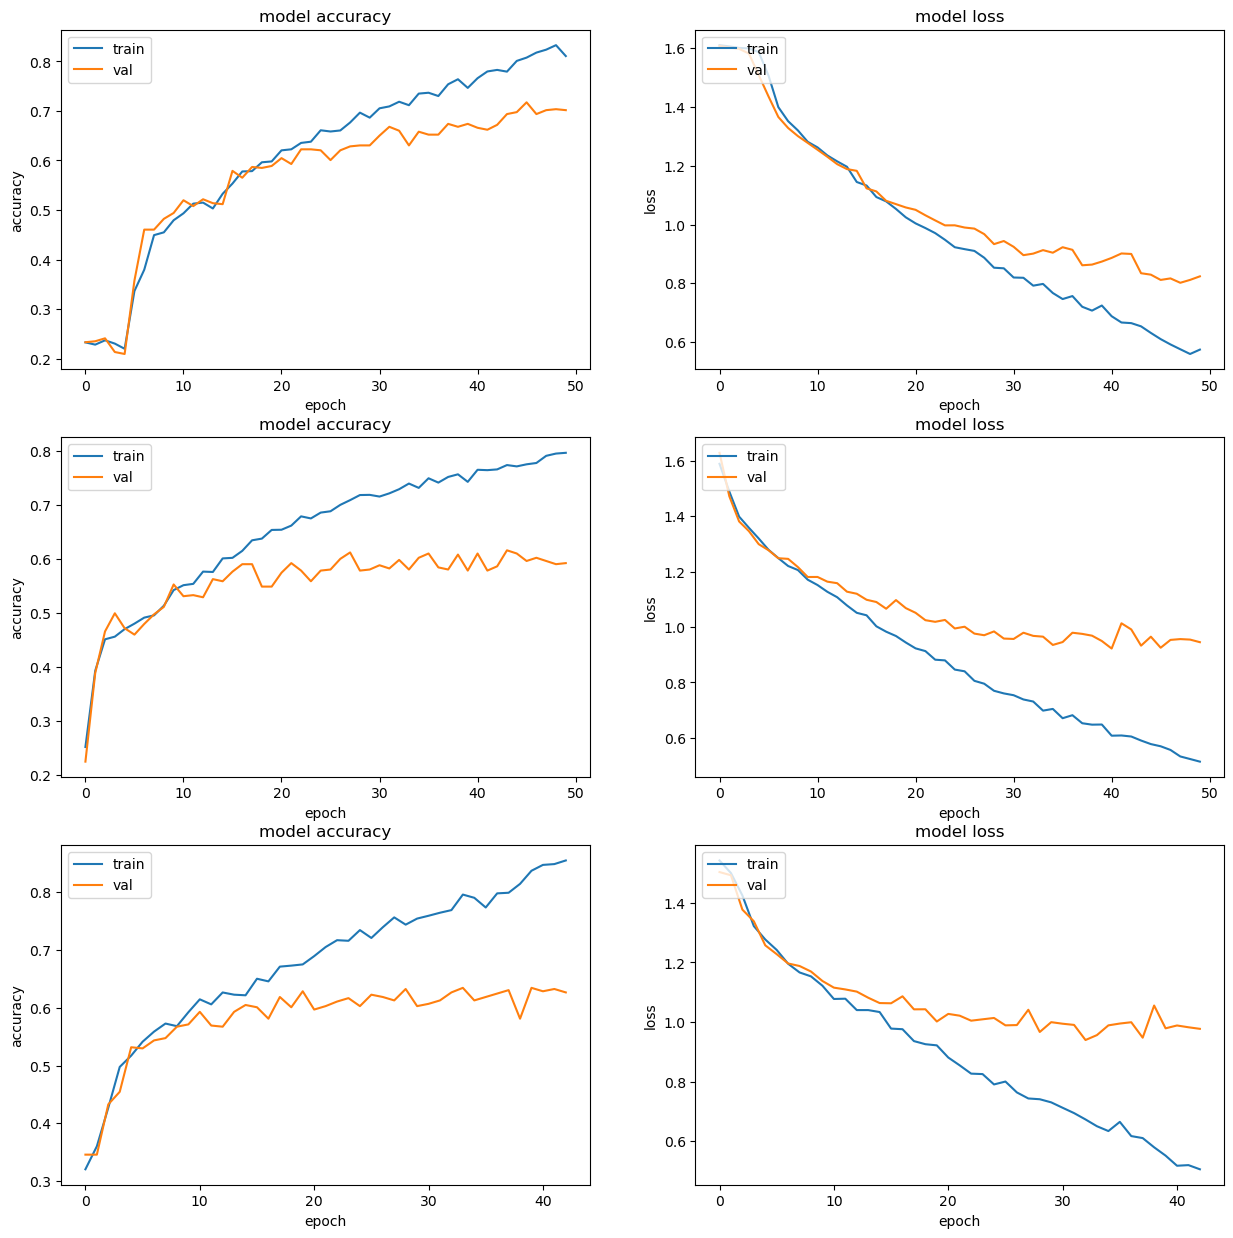

Epoch 1/50
90/90 [==============================] - 3s 19ms/step - loss: 1.5973 - accuracy: 0.2347 - val_loss: 1.5575 - val_accuracy: 0.3162
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5385 - accuracy: 0.3144 - val_loss: 1.4713 - val_accuracy: 0.4190
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4718 - accuracy: 0.3681 - val_loss: 1.3907 - val_accuracy: 0.4763
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3636 - accuracy: 0.4169 - val_loss: 1.3342 - val_accuracy: 0.4071
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3364 - accuracy: 0.4076 - val_loss: 1.2640 - val_accuracy: 0.4960
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2375 - accuracy: 0.5291 - val_loss: 1.2078 - val_accuracy: 0.5059
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2224 - accuracy: 0.5009 - val_loss: 1.1756 - val_accuracy: 0.5217
Epoch 8/50
90

90/90 [==============================] - 1s 15ms/step - loss: 1.1668 - accuracy: 0.5124 - val_loss: 1.2674 - val_accuracy: 0.4625
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1899 - accuracy: 0.4957 - val_loss: 1.1434 - val_accuracy: 0.5158
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0950 - accuracy: 0.5520 - val_loss: 1.0877 - val_accuracy: 0.5968
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0771 - accuracy: 0.5741 - val_loss: 1.1364 - val_accuracy: 0.5652
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0939 - accuracy: 0.5581 - val_loss: 1.0635 - val_accuracy: 0.5731
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0116 - accuracy: 0.6128 - val_loss: 1.0921 - val_accuracy: 0.5889
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9939 - accuracy: 0.6097 - val_loss: 1.0115 - val_accuracy: 0.5968
Epoch 14/50
90/90 [=

90/90 [==============================] - 1s 15ms/step - loss: 1.1592 - accuracy: 0.5706 - val_loss: 1.1813 - val_accuracy: 0.5356
Epoch 14/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1200 - accuracy: 0.5952 - val_loss: 1.1595 - val_accuracy: 0.5553
Epoch 15/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0892 - accuracy: 0.6150 - val_loss: 1.1451 - val_accuracy: 0.5593
Epoch 16/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0675 - accuracy: 0.6269 - val_loss: 1.1419 - val_accuracy: 0.5593
Epoch 17/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0535 - accuracy: 0.6168 - val_loss: 1.1166 - val_accuracy: 0.5771
Epoch 18/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0224 - accuracy: 0.6354 - val_loss: 1.1112 - val_accuracy: 0.5692
Epoch 19/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0353 - accuracy: 0.6276 - val_loss: 1.1322 - val_accuracy: 0.5415
Epoch 20/50
90/90 

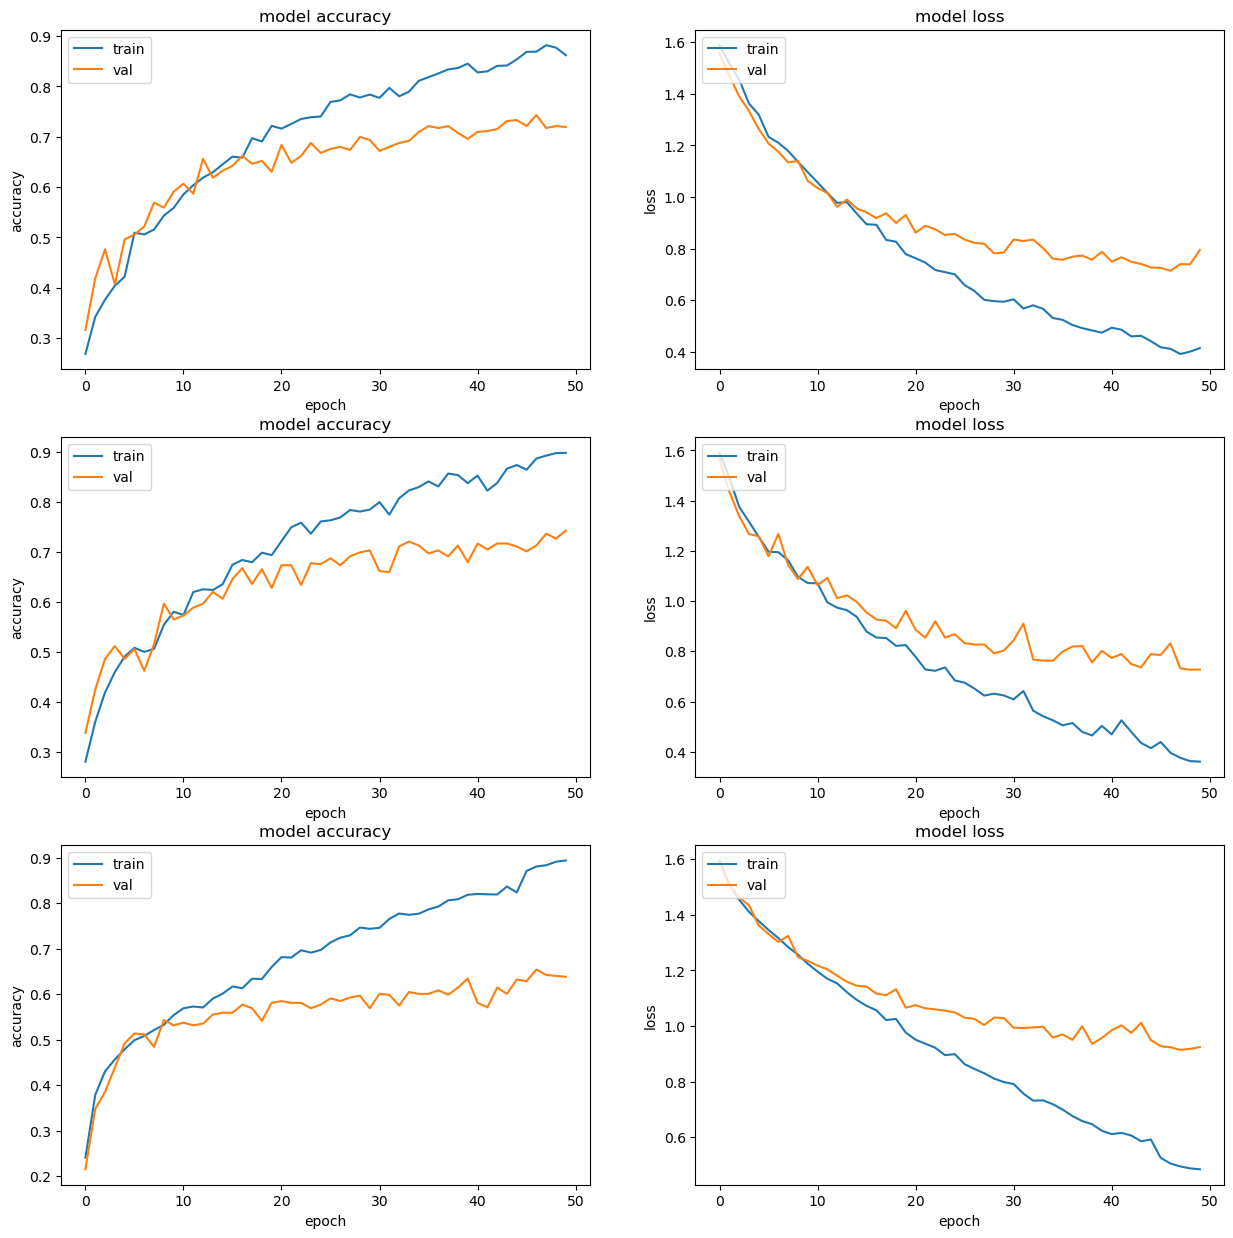

Epoch 1/50
90/90 [==============================] - 3s 19ms/step - loss: 1.6078 - accuracy: 0.2431 - val_loss: 1.6026 - val_accuracy: 0.2589
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6018 - accuracy: 0.2508 - val_loss: 1.5875 - val_accuracy: 0.2569
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5827 - accuracy: 0.2810 - val_loss: 1.5779 - val_accuracy: 0.2866
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5792 - accuracy: 0.2581 - val_loss: 1.5790 - val_accuracy: 0.2727
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5741 - accuracy: 0.2764 - val_loss: 1.5646 - val_accuracy: 0.2885
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5553 - accuracy: 0.2785 - val_loss: 1.5603 - val_accuracy: 0.2925
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5538 - accuracy: 0.2694 - val_loss: 1.5593 - val_accuracy: 0.2826
Epoch 8/50
90

90/90 [==============================] - 1s 15ms/step - loss: 1.6028 - accuracy: 0.2277 - val_loss: 1.6020 - val_accuracy: 0.2352
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6036 - accuracy: 0.2248 - val_loss: 1.6019 - val_accuracy: 0.2352
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6010 - accuracy: 0.2392 - val_loss: 1.6018 - val_accuracy: 0.2352
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5989 - accuracy: 0.2382 - val_loss: 1.6018 - val_accuracy: 0.2352
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6005 - accuracy: 0.2373 - val_loss: 1.6018 - val_accuracy: 0.2352
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6014 - accuracy: 0.2313 - val_loss: 1.6018 - val_accuracy: 0.2352
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5978 - accuracy: 0.2375 - val_loss: 1.6018 - val_accuracy: 0.2352
Epoch 14/50
90/90 [=

90/90 [==============================] - 1s 15ms/step - loss: 1.1637 - accuracy: 0.5118 - val_loss: 1.2154 - val_accuracy: 0.4842
Epoch 31/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1956 - accuracy: 0.4912 - val_loss: 1.1961 - val_accuracy: 0.4901
Epoch 32/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1831 - accuracy: 0.5053 - val_loss: 1.1993 - val_accuracy: 0.4921
Epoch 33/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1618 - accuracy: 0.5125 - val_loss: 1.1390 - val_accuracy: 0.5158
Epoch 34/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1345 - accuracy: 0.5070 - val_loss: 1.1564 - val_accuracy: 0.5079
Epoch 35/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1543 - accuracy: 0.5191 - val_loss: 1.1815 - val_accuracy: 0.5020
Epoch 36/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1503 - accuracy: 0.5229 - val_loss: 1.1491 - val_accuracy: 0.5237
Epoch 37/50
90/90 

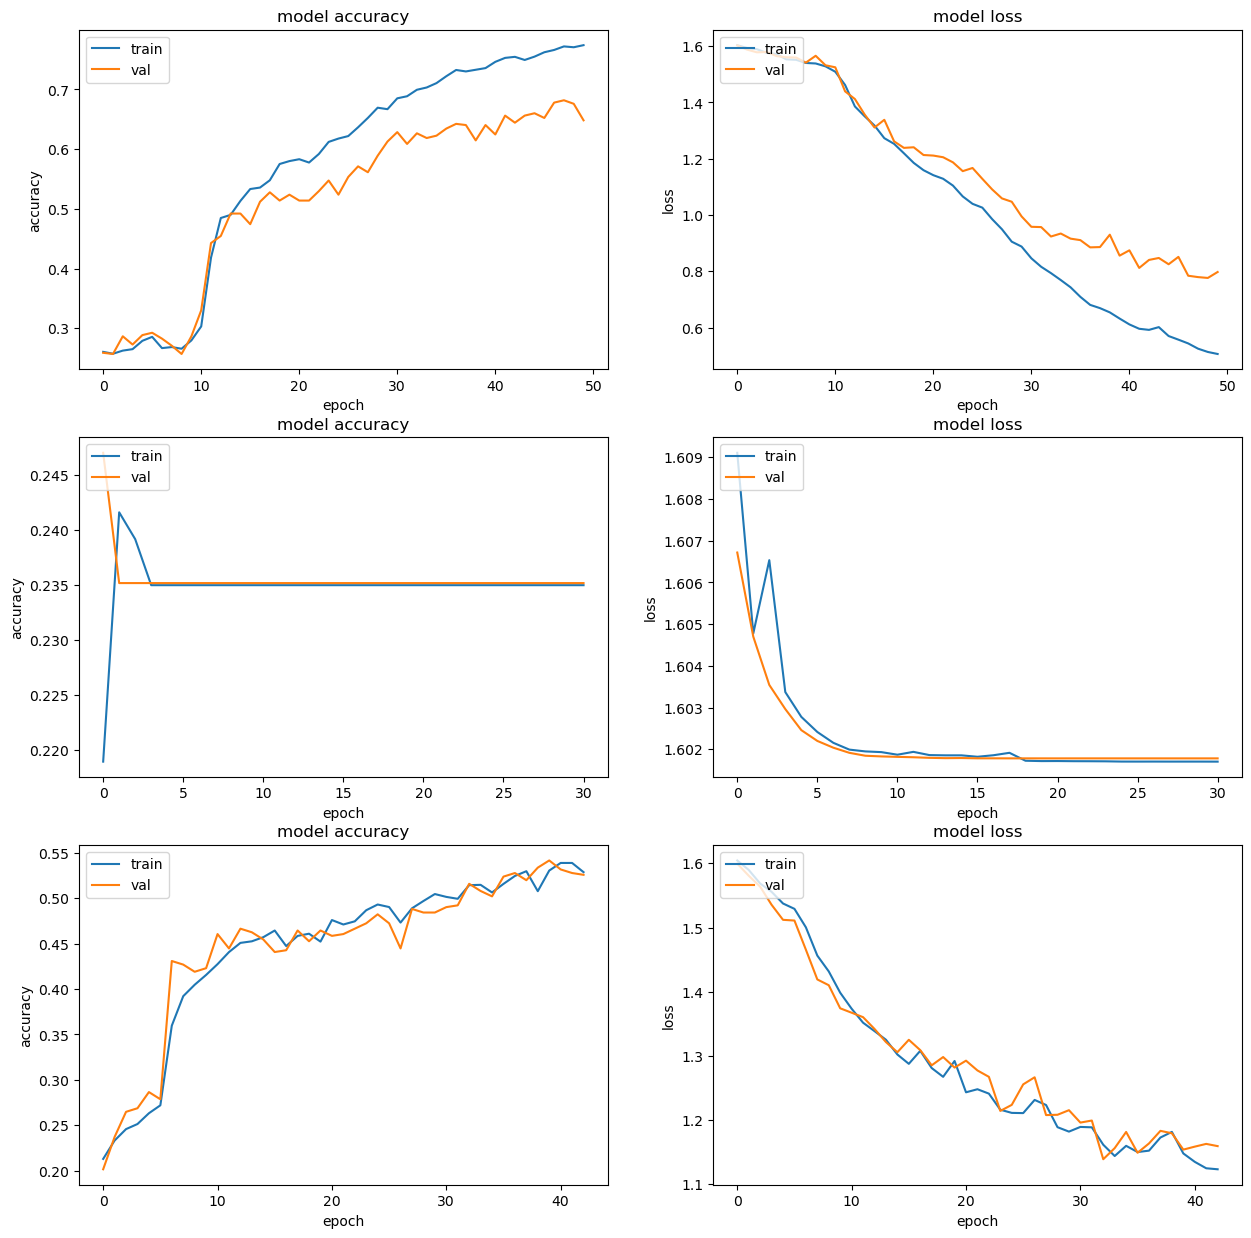

Epoch 1/50
90/90 [==============================] - 3s 19ms/step - loss: 1.5145 - accuracy: 0.3398 - val_loss: 1.3467 - val_accuracy: 0.4486
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3846 - accuracy: 0.4135 - val_loss: 1.2655 - val_accuracy: 0.5138
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3080 - accuracy: 0.4763 - val_loss: 1.2385 - val_accuracy: 0.5079
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2415 - accuracy: 0.5010 - val_loss: 1.2182 - val_accuracy: 0.5277
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2117 - accuracy: 0.5055 - val_loss: 1.1391 - val_accuracy: 0.5791
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1527 - accuracy: 0.5656 - val_loss: 1.1090 - val_accuracy: 0.5711
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1197 - accuracy: 0.5661 - val_loss: 1.0789 - val_accuracy: 0.6028
Epoch 8/50
90

90/90 [==============================] - 1s 15ms/step - loss: 1.2360 - accuracy: 0.5236 - val_loss: 1.2496 - val_accuracy: 0.5158
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2095 - accuracy: 0.5309 - val_loss: 1.1966 - val_accuracy: 0.5573
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1553 - accuracy: 0.5656 - val_loss: 1.1923 - val_accuracy: 0.5395
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1469 - accuracy: 0.5651 - val_loss: 1.1322 - val_accuracy: 0.5929
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1020 - accuracy: 0.5821 - val_loss: 1.1213 - val_accuracy: 0.5672
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0697 - accuracy: 0.6211 - val_loss: 1.0994 - val_accuracy: 0.6028
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0372 - accuracy: 0.6234 - val_loss: 1.0838 - val_accuracy: 0.6166
Epoch 13/50
90/90 [==

90/90 [==============================] - 1s 15ms/step - loss: 1.1172 - accuracy: 0.5401 - val_loss: 1.1339 - val_accuracy: 0.5455
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0731 - accuracy: 0.5699 - val_loss: 1.1337 - val_accuracy: 0.5336
Epoch 14/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0542 - accuracy: 0.5706 - val_loss: 1.1110 - val_accuracy: 0.5375
Epoch 15/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0319 - accuracy: 0.5919 - val_loss: 1.0654 - val_accuracy: 0.5830
Epoch 16/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9815 - accuracy: 0.5972 - val_loss: 1.0522 - val_accuracy: 0.5632
Epoch 17/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9476 - accuracy: 0.6152 - val_loss: 1.0407 - val_accuracy: 0.5613
Epoch 18/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9307 - accuracy: 0.6234 - val_loss: 1.0380 - val_accuracy: 0.5909
Epoch 19/50
90/90 

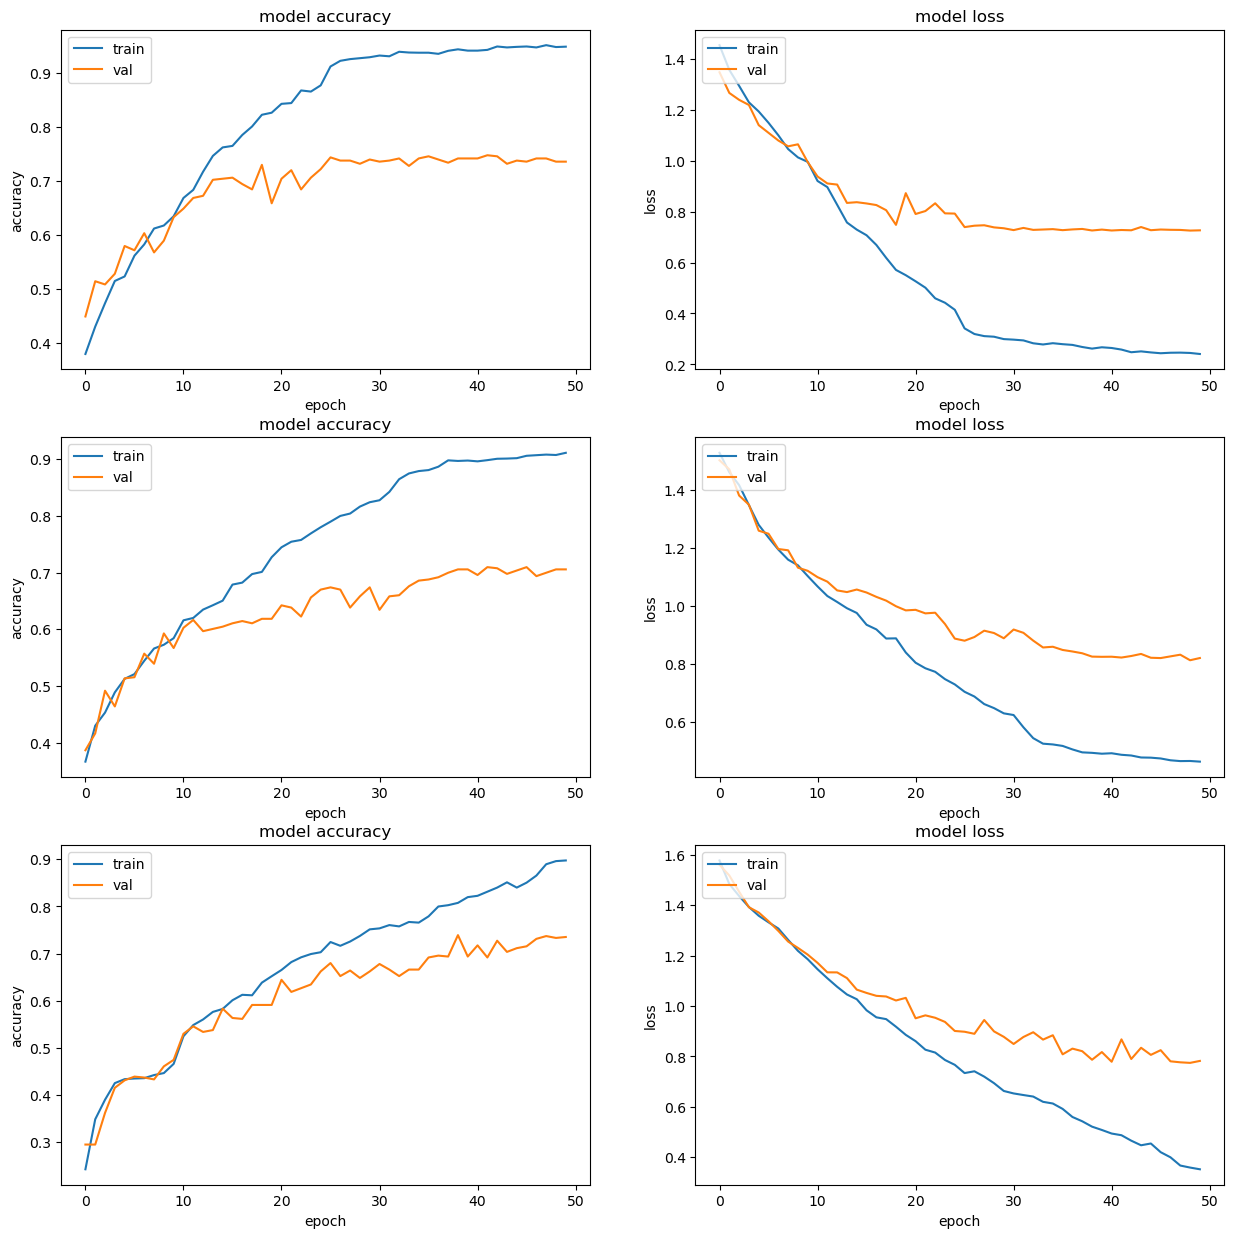

In [13]:
emodb2 = experiments(metadata, [data0s, data1s, data2s, data3s], y, get_m)

# EMOVO

In [14]:
metadata, data0, data1, data2, data3, y = load_data('emovo')
metadata

path     filename  chunk  \
0     /datasets/nicolas_facchinetti/emodb/data/14b09...  14b09Ac.wav      0   
1     /datasets/nicolas_facchinetti/emodb/data/14b09...  14b09Ac.wav      0   
2     /datasets/nicolas_facchinetti/emodb/data/14b09...  14b09Ac.wav      0   
3     /datasets/nicolas_facchinetti/emodb/data/14b09...  14b09Ac.wav      0   
4     /datasets/nicolas_facchinetti/emodb/data/14b09...  14b09Ac.wav      0   
...                                                 ...          ...    ...   
3740  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      0   
3741  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      1   
3742  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      0   
3743  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      0   
3744  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      0   

      label  actor gender  mod  
0      fear     14      f    0  
1      fear     14      f    1  
2      fear     14      f    1  
3      fear     14      f    1  
4      fear     14      f    1  
...     ...    ...    ...  ...  
3740  happy      8      f    2  
3741  happy      8      f    2  
3742  happy      8      f    2  
3743  happy      8      f    2  
3744  happy      8      f    2  

[3745 rows x 7 columns]

In [15]:
data0.shape, data1.shape, data2.shape, data3.shape, y.shape

((3745, 261, 128, 1),
 (3745, 261, 128, 1),
 (3745, 261, 128, 1),
 (3745, 261, 128, 1),
 (3745, 5))

## Without standardization

Epoch 1/50
90/90 [==============================] - 3s 19ms/step - loss: 1.6101 - accuracy: 0.2344 - val_loss: 1.5943 - val_accuracy: 0.2431
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4887 - accuracy: 0.3736 - val_loss: 1.4038 - val_accuracy: 0.4289
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4044 - accuracy: 0.4128 - val_loss: 1.3530 - val_accuracy: 0.4506
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3508 - accuracy: 0.4389 - val_loss: 1.3441 - val_accuracy: 0.4348
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3178 - accuracy: 0.4538 - val_loss: 1.3201 - val_accuracy: 0.4466
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2804 - accuracy: 0.4624 - val_loss: 1.2536 - val_accuracy: 0.4763
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2210 - accuracy: 0.4825 - val_loss: 1.1951 - val_accuracy: 0.4901
Epoch 8/50
90

90/90 [==============================] - 1s 15ms/step - loss: 1.0516 - accuracy: 0.6107 - val_loss: 1.2239 - val_accuracy: 0.4980
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0337 - accuracy: 0.6240 - val_loss: 1.1154 - val_accuracy: 0.5711
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9757 - accuracy: 0.6416 - val_loss: 1.2694 - val_accuracy: 0.4763
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9440 - accuracy: 0.6624 - val_loss: 1.0743 - val_accuracy: 0.5791
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9667 - accuracy: 0.6380 - val_loss: 1.0173 - val_accuracy: 0.6146
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8753 - accuracy: 0.6849 - val_loss: 1.1305 - val_accuracy: 0.5494
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8535 - accuracy: 0.7063 - val_loss: 1.0790 - val_accuracy: 0.5929
Epoch 13/50
90/90 [==

90/90 [==============================] - 1s 15ms/step - loss: 1.0269 - accuracy: 0.6282 - val_loss: 1.2708 - val_accuracy: 0.4921
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0455 - accuracy: 0.5957 - val_loss: 1.1738 - val_accuracy: 0.5791
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9962 - accuracy: 0.6404 - val_loss: 1.2286 - val_accuracy: 0.5356
Epoch 14/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9858 - accuracy: 0.6367 - val_loss: 1.1198 - val_accuracy: 0.5672
Epoch 15/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9637 - accuracy: 0.6540 - val_loss: 1.1022 - val_accuracy: 0.5870
Epoch 16/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9283 - accuracy: 0.6621 - val_loss: 1.1110 - val_accuracy: 0.5751
Epoch 17/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8835 - accuracy: 0.6972 - val_loss: 1.1162 - val_accuracy: 0.5751
Epoch 18/50
90/90 

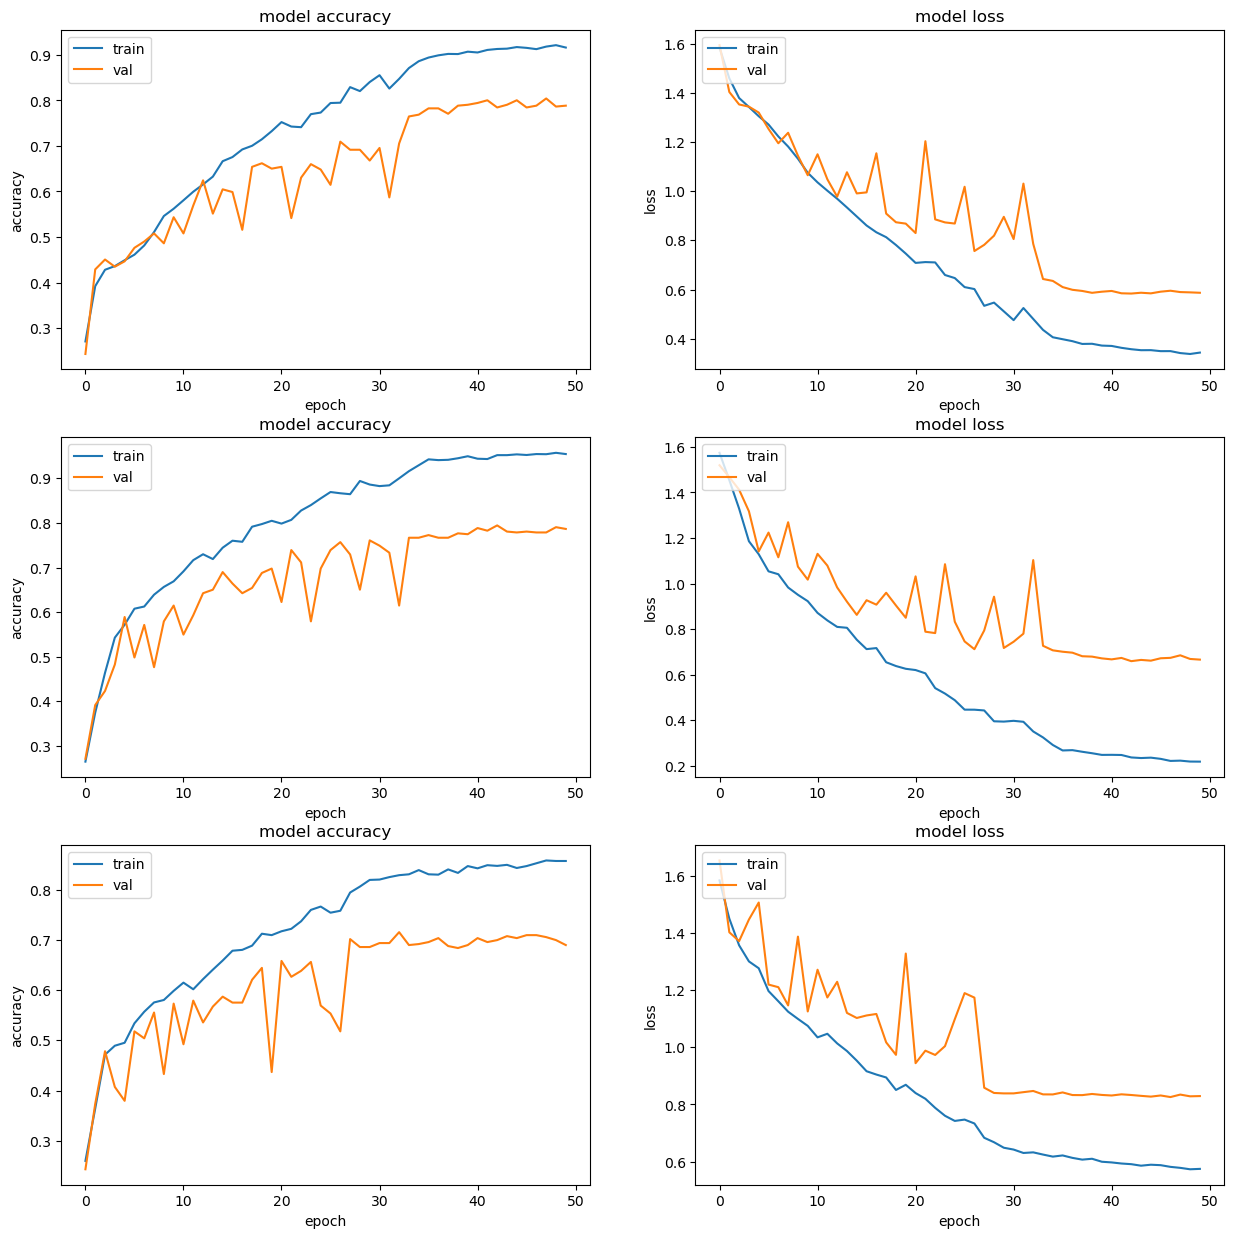

Epoch 1/50
90/90 [==============================] - 3s 19ms/step - loss: 1.6083 - accuracy: 0.2290 - val_loss: 1.6049 - val_accuracy: 0.2352
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6076 - accuracy: 0.2266 - val_loss: 1.6040 - val_accuracy: 0.2352
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5928 - accuracy: 0.2629 - val_loss: 1.8482 - val_accuracy: 0.2352
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4206 - accuracy: 0.4064 - val_loss: 2.1420 - val_accuracy: 0.2332
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2996 - accuracy: 0.4540 - val_loss: 1.6543 - val_accuracy: 0.1660
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2966 - accuracy: 0.4534 - val_loss: 2.2338 - val_accuracy: 0.2391
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2346 - accuracy: 0.4905 - val_loss: 1.6591 - val_accuracy: 0.2846
Epoch 8/50
90

Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5938 - accuracy: 0.2633 - val_loss: 1.7645 - val_accuracy: 0.2352
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4077 - accuracy: 0.4097 - val_loss: 1.5930 - val_accuracy: 0.2451
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3225 - accuracy: 0.4342 - val_loss: 1.9630 - val_accuracy: 0.2332
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2855 - accuracy: 0.4517 - val_loss: 1.5279 - val_accuracy: 0.3004
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2232 - accuracy: 0.4826 - val_loss: 1.5252 - val_accuracy: 0.3340
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2475 - accuracy: 0.4767 - val_loss: 1.9517 - val_accuracy: 0.2332
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1967 - accuracy: 0.4877 - val_loss: 1.9344 - val_accuracy: 0.2411
Epoch 13/5

90/90 [==============================] - 1s 15ms/step - loss: 1.1535 - accuracy: 0.5179 - val_loss: 1.6707 - val_accuracy: 0.2490
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1296 - accuracy: 0.5237 - val_loss: 1.3224 - val_accuracy: 0.4605
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1218 - accuracy: 0.5229 - val_loss: 1.1548 - val_accuracy: 0.5316
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1158 - accuracy: 0.5428 - val_loss: 1.1430 - val_accuracy: 0.5138
Epoch 14/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1144 - accuracy: 0.5440 - val_loss: 1.5822 - val_accuracy: 0.3518
Epoch 15/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1052 - accuracy: 0.5390 - val_loss: 1.2305 - val_accuracy: 0.5217
Epoch 16/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1148 - accuracy: 0.5366 - val_loss: 1.1672 - val_accuracy: 0.5020
Epoch 17/50
90/90 

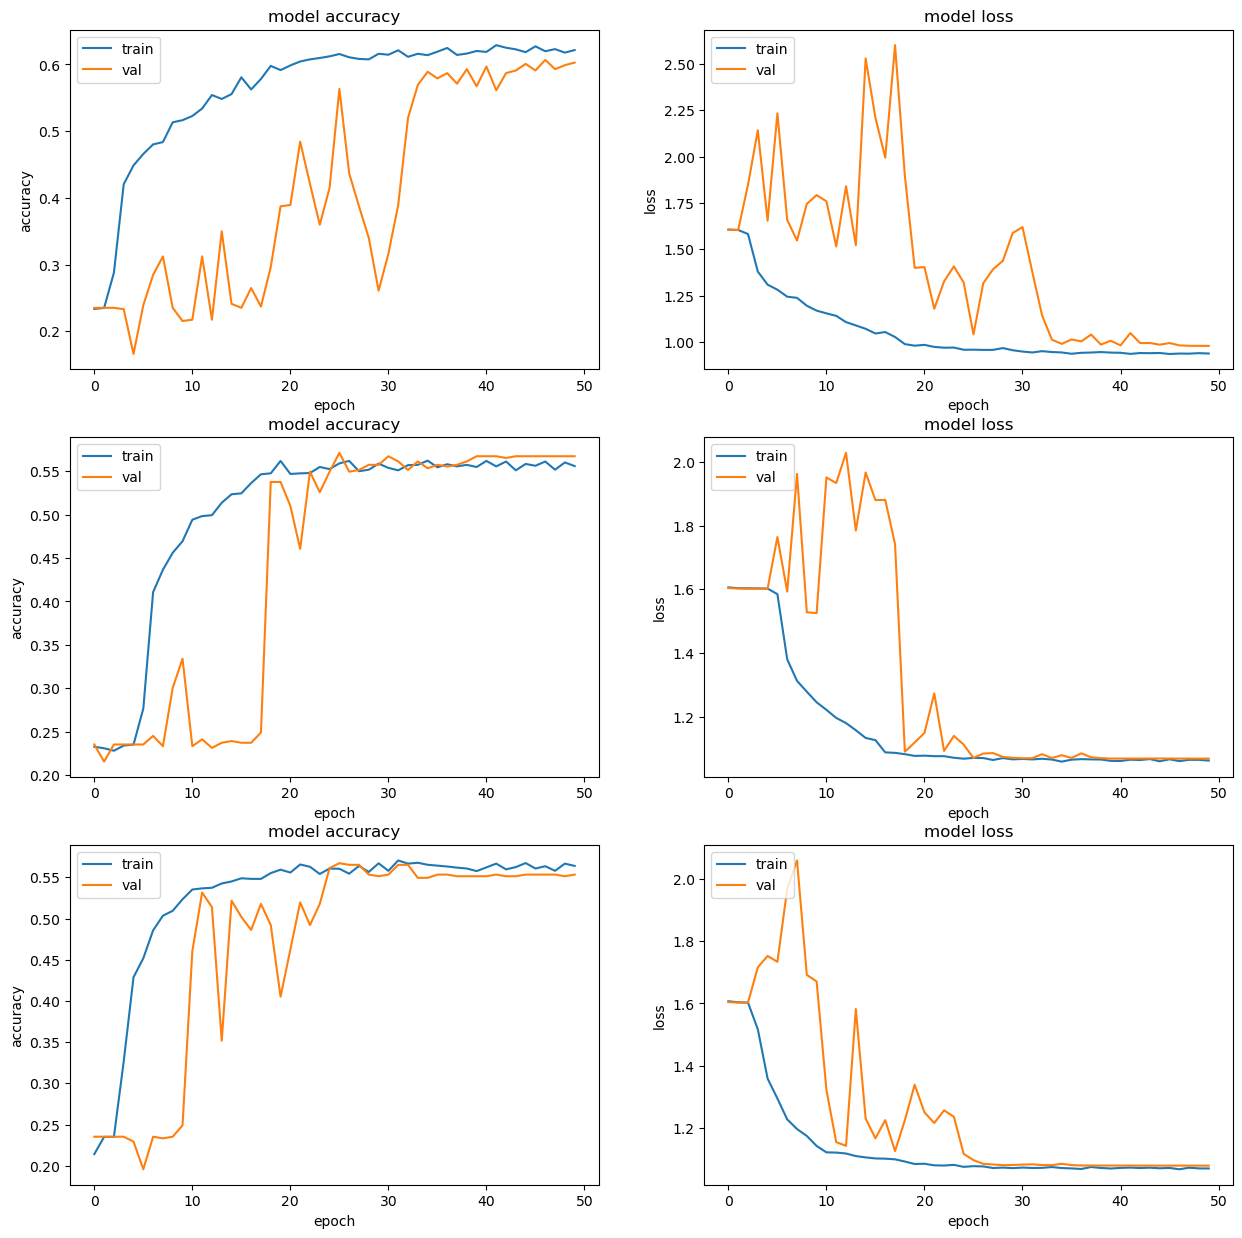

Epoch 1/50
90/90 [==============================] - 3s 18ms/step - loss: 1.5228 - accuracy: 0.3407 - val_loss: 1.5482 - val_accuracy: 0.2708
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3400 - accuracy: 0.4491 - val_loss: 1.3816 - val_accuracy: 0.4802
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2472 - accuracy: 0.5011 - val_loss: 1.3561 - val_accuracy: 0.3992
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2486 - accuracy: 0.4950 - val_loss: 1.2386 - val_accuracy: 0.5000
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1751 - accuracy: 0.5219 - val_loss: 1.2127 - val_accuracy: 0.5099
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1402 - accuracy: 0.5394 - val_loss: 1.0969 - val_accuracy: 0.5474
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0510 - accuracy: 0.6212 - val_loss: 1.0840 - val_accuracy: 0.5534
Epoch 8/50
90

Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2171 - accuracy: 0.5213 - val_loss: 1.2740 - val_accuracy: 0.4881
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1833 - accuracy: 0.5332 - val_loss: 1.2103 - val_accuracy: 0.5455
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1188 - accuracy: 0.5666 - val_loss: 1.6977 - val_accuracy: 0.3340
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0903 - accuracy: 0.5746 - val_loss: 1.1563 - val_accuracy: 0.5474
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0633 - accuracy: 0.5937 - val_loss: 1.3036 - val_accuracy: 0.4545
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0121 - accuracy: 0.5999 - val_loss: 1.0814 - val_accuracy: 0.5751
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9882 - accuracy: 0.6143 - val_loss: 1.0880 - val_accuracy: 0.5494
Epoch 14/

Epoch 20/50
90/90 [==============================] - 1s 15ms/step - loss: 0.6107 - accuracy: 0.8088 - val_loss: 1.1773 - val_accuracy: 0.5672
Epoch 21/50
90/90 [==============================] - 1s 15ms/step - loss: 0.5754 - accuracy: 0.8112 - val_loss: 1.4949 - val_accuracy: 0.4407

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 22/50
90/90 [==============================] - 1s 15ms/step - loss: 0.6144 - accuracy: 0.7909 - val_loss: 0.7460 - val_accuracy: 0.7273
Epoch 23/50
90/90 [==============================] - 1s 15ms/step - loss: 0.5235 - accuracy: 0.8378 - val_loss: 0.6989 - val_accuracy: 0.7530
Epoch 24/50
90/90 [==============================] - 1s 15ms/step - loss: 0.4942 - accuracy: 0.8545 - val_loss: 0.6958 - val_accuracy: 0.7372
Epoch 25/50
90/90 [==============================] - 1s 15ms/step - loss: 0.4890 - accuracy: 0.8664 - val_loss: 0.7144 - val_accuracy: 0.7332
Epoch 26/50
90/90 [==============================] - 1s 15ms/step 

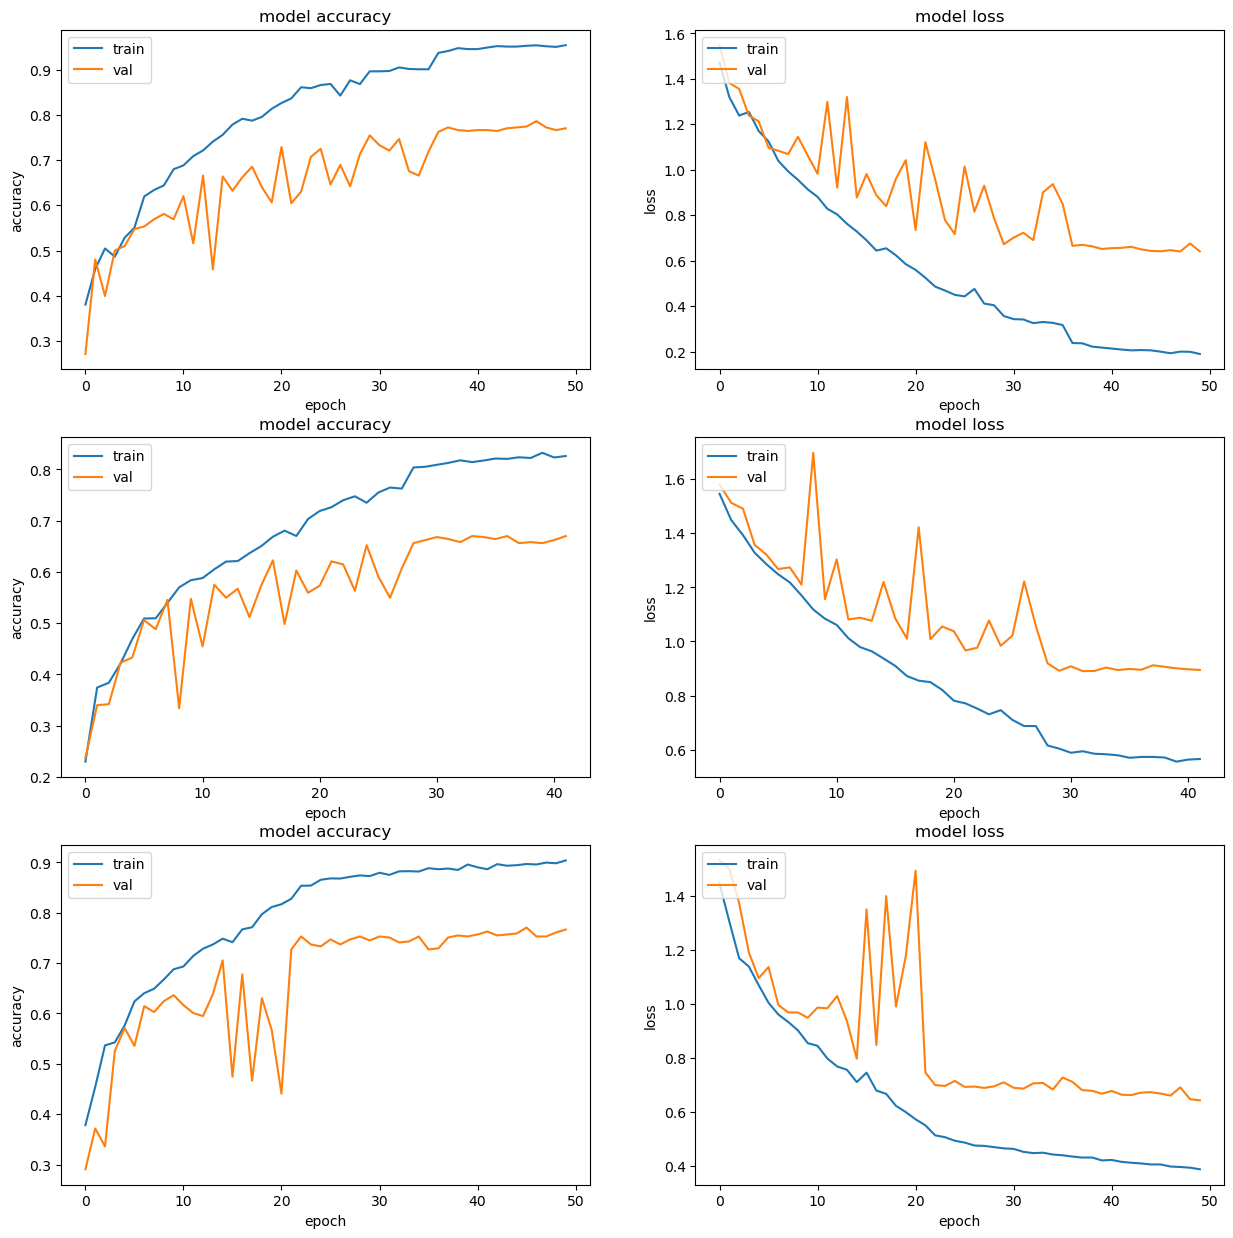

Epoch 1/50
90/90 [==============================] - 3s 18ms/step - loss: 1.5991 - accuracy: 0.2911 - val_loss: 1.6318 - val_accuracy: 0.2154
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5740 - accuracy: 0.3386 - val_loss: 1.5819 - val_accuracy: 0.2925
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5348 - accuracy: 0.3746 - val_loss: 1.5595 - val_accuracy: 0.2945
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4984 - accuracy: 0.3902 - val_loss: 1.4599 - val_accuracy: 0.3478
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4016 - accuracy: 0.4362 - val_loss: 1.3905 - val_accuracy: 0.4783
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3480 - accuracy: 0.4924 - val_loss: 1.3336 - val_accuracy: 0.5158
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2960 - accuracy: 0.4983 - val_loss: 1.2751 - val_accuracy: 0.5178
Epoch 8/50
90

Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1910 - accuracy: 0.5661 - val_loss: 1.1978 - val_accuracy: 0.5711
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1030 - accuracy: 0.6251 - val_loss: 1.1339 - val_accuracy: 0.5909
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0801 - accuracy: 0.6217 - val_loss: 1.1321 - val_accuracy: 0.5909
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0430 - accuracy: 0.6345 - val_loss: 1.1216 - val_accuracy: 0.5949
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9977 - accuracy: 0.6622 - val_loss: 1.1044 - val_accuracy: 0.5949
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9612 - accuracy: 0.6893 - val_loss: 1.0511 - val_accuracy: 0.6166
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9298 - accuracy: 0.6866 - val_loss: 1.0293 - val_accuracy: 0.6285
Epoch 14/

90/90 [==============================] - 1s 15ms/step - loss: 0.8264 - accuracy: 0.7259 - val_loss: 0.9847 - val_accuracy: 0.6324
Epoch 16/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7897 - accuracy: 0.7351 - val_loss: 0.9480 - val_accuracy: 0.6640
Epoch 17/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7413 - accuracy: 0.7577 - val_loss: 0.9229 - val_accuracy: 0.6798
Epoch 18/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7287 - accuracy: 0.7570 - val_loss: 0.9131 - val_accuracy: 0.6798
Epoch 19/50
90/90 [==============================] - 1s 15ms/step - loss: 0.6968 - accuracy: 0.7699 - val_loss: 1.0243 - val_accuracy: 0.6067
Epoch 20/50
90/90 [==============================] - 1s 15ms/step - loss: 0.6593 - accuracy: 0.7861 - val_loss: 0.8619 - val_accuracy: 0.6957
Epoch 21/50
90/90 [==============================] - 1s 15ms/step - loss: 0.6386 - accuracy: 0.7969 - val_loss: 0.9151 - val_accuracy: 0.6719
Epoch 22/50
90/90 

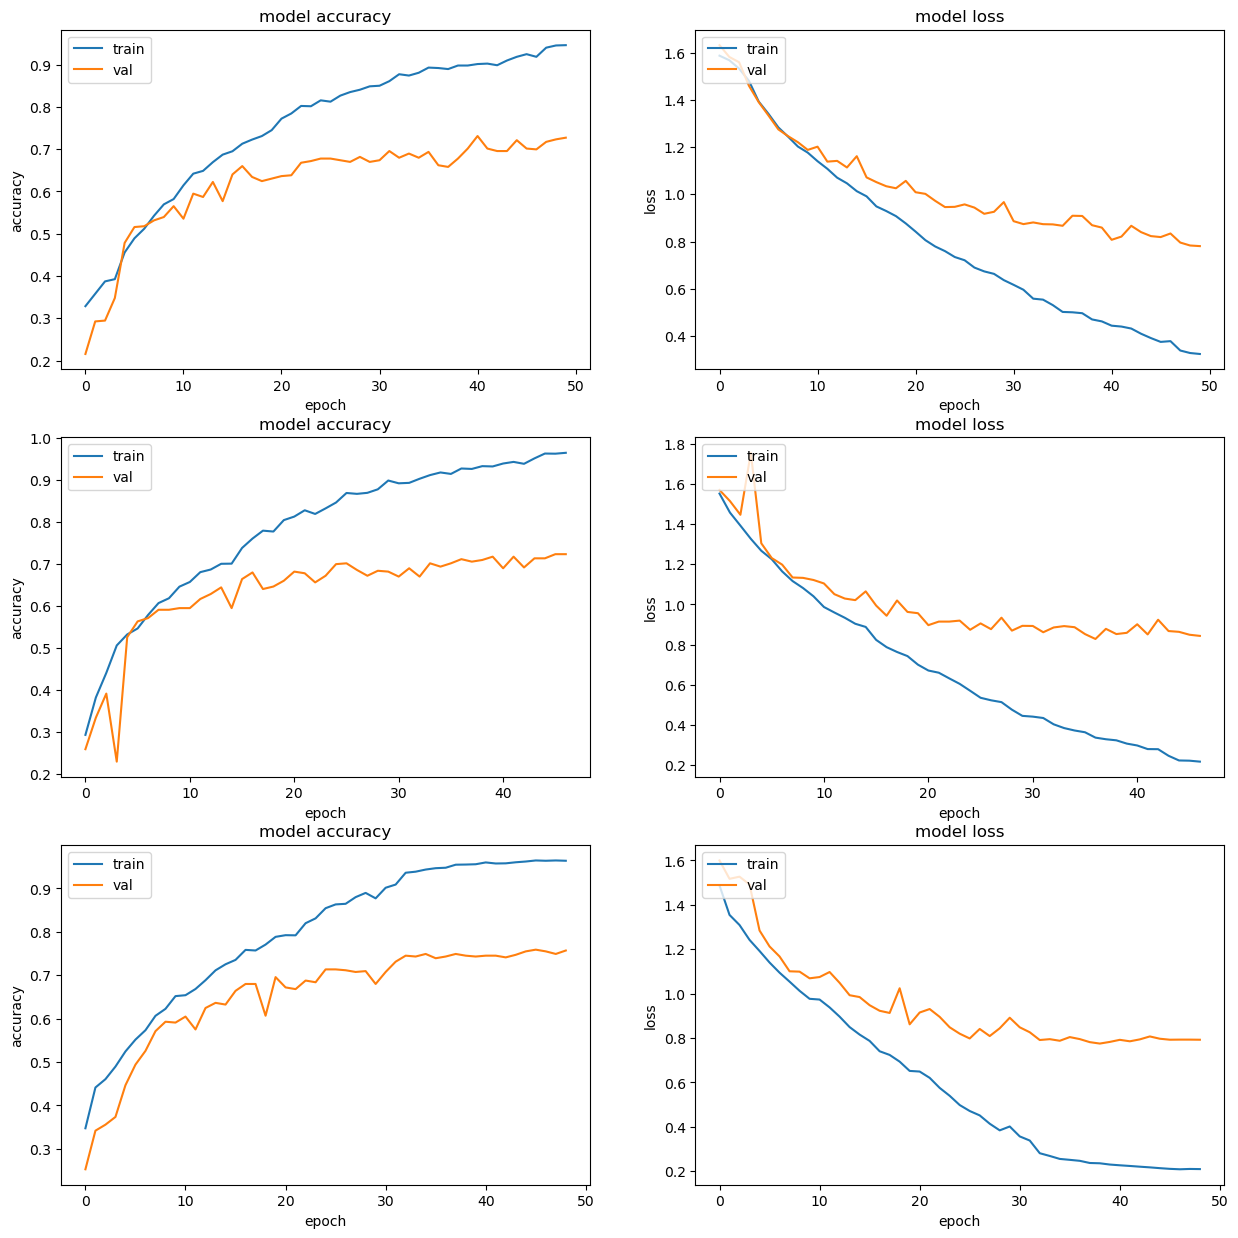

In [16]:
emovo1 = experiments(metadata, [data0, data1, data2, data3], y, get_m)

## With standardization

In [17]:
data0s = standardize(data0)
data1s = standardize(data1)
data2s = standardize(data2)
data3s = standardize(data3)

Epoch 1/50
90/90 [==============================] - 3s 19ms/step - loss: 1.5946 - accuracy: 0.2898 - val_loss: 1.5712 - val_accuracy: 0.3794
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5582 - accuracy: 0.3610 - val_loss: 1.5353 - val_accuracy: 0.3834
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4914 - accuracy: 0.4276 - val_loss: 1.4461 - val_accuracy: 0.3953
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4079 - accuracy: 0.3971 - val_loss: 1.3883 - val_accuracy: 0.4269
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3303 - accuracy: 0.4564 - val_loss: 1.3967 - val_accuracy: 0.4545
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3029 - accuracy: 0.4942 - val_loss: 1.3292 - val_accuracy: 0.4802
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2593 - accuracy: 0.5189 - val_loss: 1.3013 - val_accuracy: 0.4664
Epoch 8/50
90

90/90 [==============================] - 1s 15ms/step - loss: 1.2745 - accuracy: 0.4555 - val_loss: 1.2689 - val_accuracy: 0.4565
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2550 - accuracy: 0.4812 - val_loss: 1.2634 - val_accuracy: 0.4901
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2197 - accuracy: 0.5055 - val_loss: 1.2127 - val_accuracy: 0.4941
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1618 - accuracy: 0.5319 - val_loss: 1.2337 - val_accuracy: 0.5277
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1506 - accuracy: 0.5566 - val_loss: 1.2247 - val_accuracy: 0.4941
Epoch 14/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1783 - accuracy: 0.5179 - val_loss: 1.1936 - val_accuracy: 0.5277
Epoch 15/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1141 - accuracy: 0.5665 - val_loss: 1.2221 - val_accuracy: 0.4822
Epoch 16/50
90/90 

90/90 [==============================] - 1s 15ms/step - loss: 1.1636 - accuracy: 0.5027 - val_loss: 1.1676 - val_accuracy: 0.4901
Epoch 16/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1185 - accuracy: 0.5214 - val_loss: 1.1559 - val_accuracy: 0.5059
Epoch 17/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0873 - accuracy: 0.5434 - val_loss: 1.1557 - val_accuracy: 0.5138
Epoch 18/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1155 - accuracy: 0.5125 - val_loss: 1.1438 - val_accuracy: 0.5059
Epoch 19/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0815 - accuracy: 0.5355 - val_loss: 1.1190 - val_accuracy: 0.5277
Epoch 20/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0757 - accuracy: 0.5533 - val_loss: 1.1032 - val_accuracy: 0.5079
Epoch 21/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0445 - accuracy: 0.5697 - val_loss: 1.1054 - val_accuracy: 0.5336
Epoch 22/50
90/90 

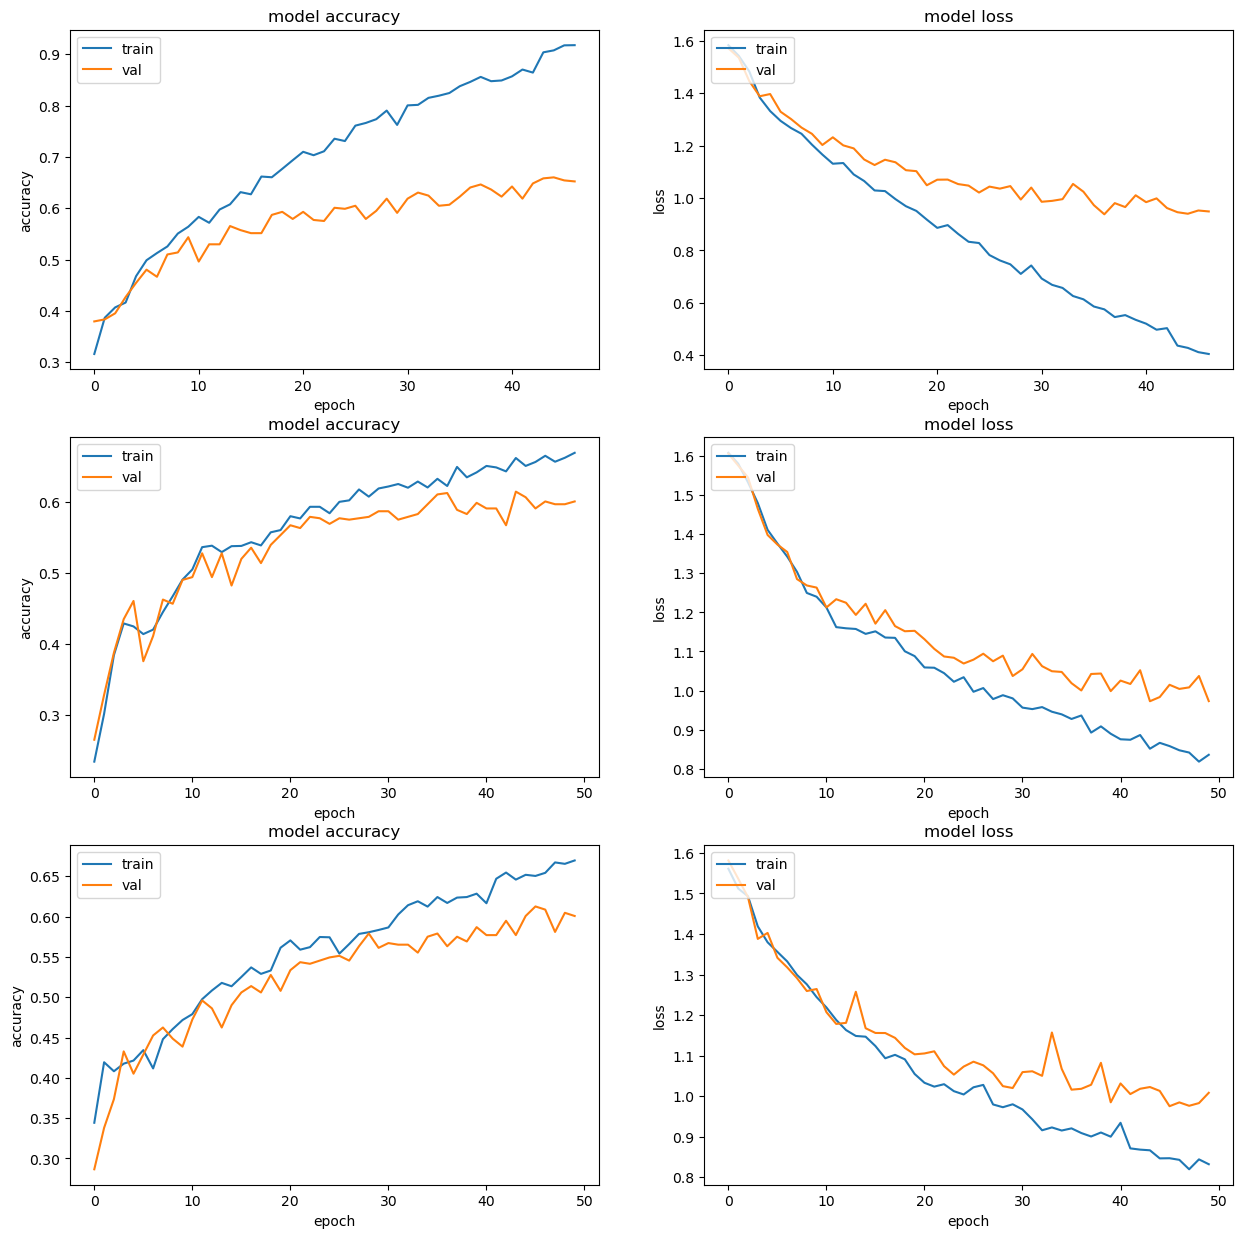

Epoch 1/50
90/90 [==============================] - 3s 19ms/step - loss: 1.5774 - accuracy: 0.2919 - val_loss: 1.5156 - val_accuracy: 0.3696
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4934 - accuracy: 0.3661 - val_loss: 1.4525 - val_accuracy: 0.4269
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4277 - accuracy: 0.4174 - val_loss: 1.3631 - val_accuracy: 0.4723
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3846 - accuracy: 0.4293 - val_loss: 1.3363 - val_accuracy: 0.4545
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3430 - accuracy: 0.4338 - val_loss: 1.3051 - val_accuracy: 0.4743
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3086 - accuracy: 0.4531 - val_loss: 1.2531 - val_accuracy: 0.5000
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2757 - accuracy: 0.4515 - val_loss: 1.2626 - val_accuracy: 0.4704
Epoch 8/50
90

90/90 [==============================] - 1s 15ms/step - loss: 1.1327 - accuracy: 0.5777 - val_loss: 1.1293 - val_accuracy: 0.5771
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1242 - accuracy: 0.5819 - val_loss: 1.1623 - val_accuracy: 0.5415
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0885 - accuracy: 0.5938 - val_loss: 1.1097 - val_accuracy: 0.5810
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0239 - accuracy: 0.6302 - val_loss: 1.0926 - val_accuracy: 0.5751
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9739 - accuracy: 0.6374 - val_loss: 1.0775 - val_accuracy: 0.5830
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9589 - accuracy: 0.6360 - val_loss: 1.0335 - val_accuracy: 0.6245
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9382 - accuracy: 0.6403 - val_loss: 0.9712 - val_accuracy: 0.6265
Epoch 14/50
90/90 [=

90/90 [==============================] - 1s 15ms/step - loss: 1.1164 - accuracy: 0.5551 - val_loss: 1.1434 - val_accuracy: 0.5336
Epoch 14/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1166 - accuracy: 0.5473 - val_loss: 1.1064 - val_accuracy: 0.5534
Epoch 15/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0782 - accuracy: 0.5789 - val_loss: 1.0910 - val_accuracy: 0.5771
Epoch 16/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0432 - accuracy: 0.5952 - val_loss: 1.0683 - val_accuracy: 0.5731
Epoch 17/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0221 - accuracy: 0.5948 - val_loss: 1.0875 - val_accuracy: 0.5652
Epoch 18/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0077 - accuracy: 0.6134 - val_loss: 1.0379 - val_accuracy: 0.5850
Epoch 19/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9642 - accuracy: 0.6224 - val_loss: 1.0394 - val_accuracy: 0.5929
Epoch 20/50
90/90 

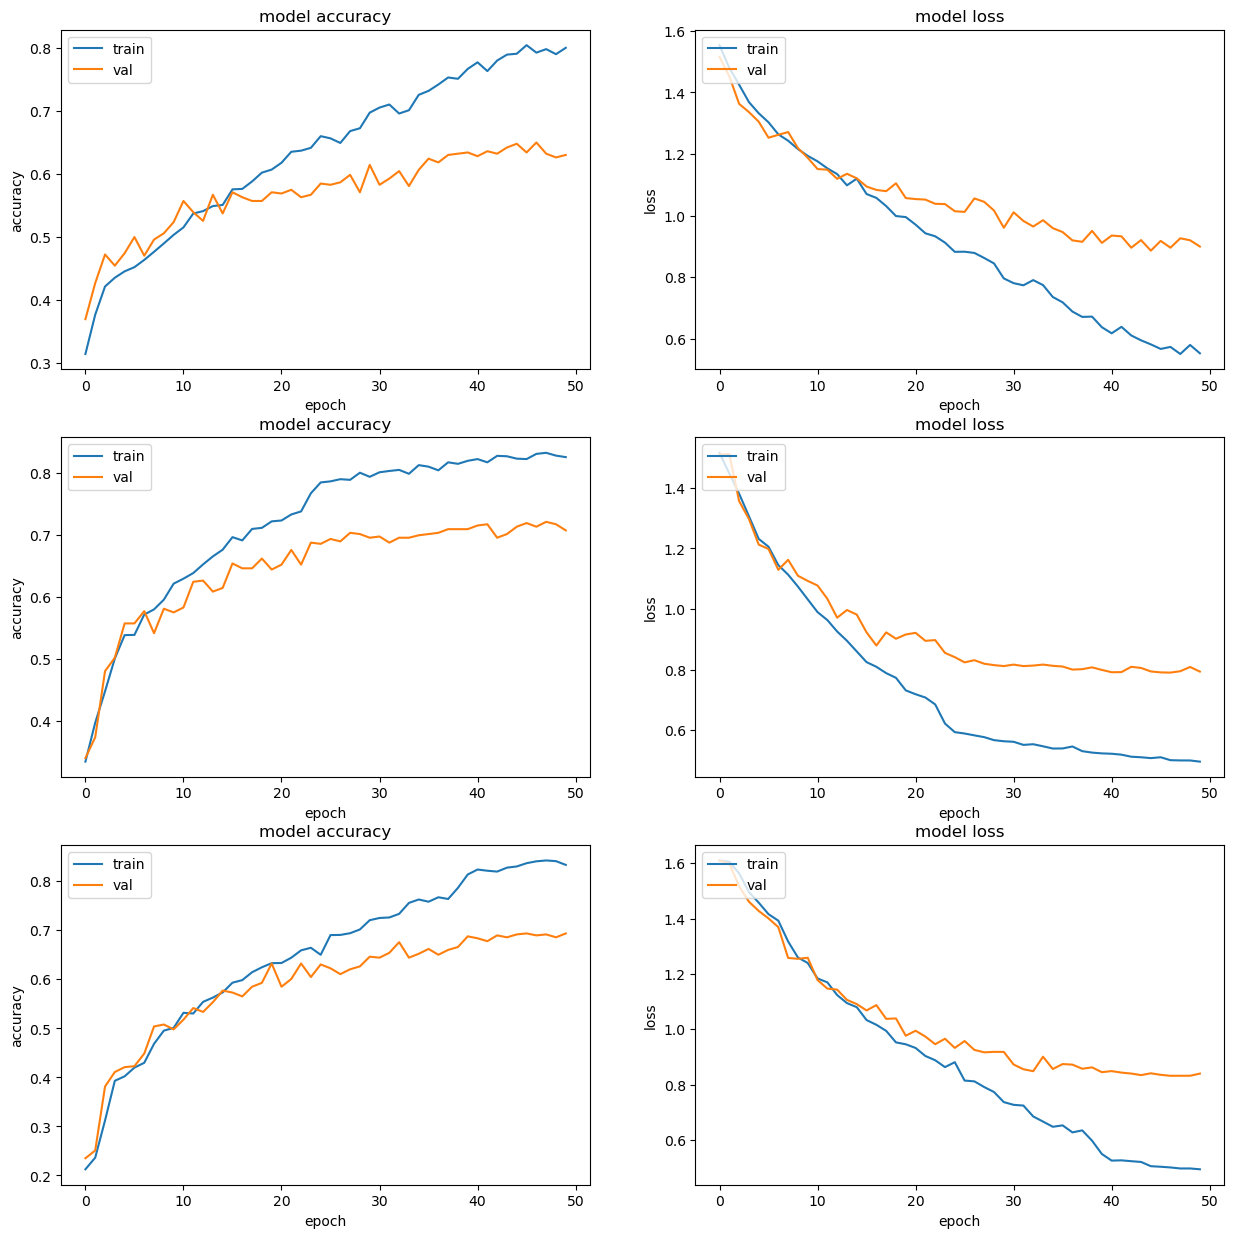

Epoch 1/50
90/90 [==============================] - 3s 18ms/step - loss: 1.6075 - accuracy: 0.2033 - val_loss: 1.5459 - val_accuracy: 0.2312
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5251 - accuracy: 0.3354 - val_loss: 1.5020 - val_accuracy: 0.3182
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4976 - accuracy: 0.3652 - val_loss: 1.4730 - val_accuracy: 0.3794
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4690 - accuracy: 0.3839 - val_loss: 1.3822 - val_accuracy: 0.4427
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4095 - accuracy: 0.4204 - val_loss: 1.3373 - val_accuracy: 0.4664
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3672 - accuracy: 0.4309 - val_loss: 1.3238 - val_accuracy: 0.3933
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3059 - accuracy: 0.4446 - val_loss: 1.2797 - val_accuracy: 0.4526
Epoch 8/50
90

90/90 [==============================] - 1s 15ms/step - loss: 1.2244 - accuracy: 0.5102 - val_loss: 1.2425 - val_accuracy: 0.4941
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1988 - accuracy: 0.5153 - val_loss: 1.2387 - val_accuracy: 0.5119
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1813 - accuracy: 0.5165 - val_loss: 1.1645 - val_accuracy: 0.5336
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1210 - accuracy: 0.5571 - val_loss: 1.1377 - val_accuracy: 0.5395
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1049 - accuracy: 0.5573 - val_loss: 1.1498 - val_accuracy: 0.5455
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0794 - accuracy: 0.5809 - val_loss: 1.1412 - val_accuracy: 0.5415
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0236 - accuracy: 0.6154 - val_loss: 1.1320 - val_accuracy: 0.5573
Epoch 14/50
90/90 [=

90/90 [==============================] - 1s 15ms/step - loss: 1.0575 - accuracy: 0.5411 - val_loss: 1.0891 - val_accuracy: 0.5395
Epoch 14/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0514 - accuracy: 0.5474 - val_loss: 1.0979 - val_accuracy: 0.5217
Epoch 15/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0097 - accuracy: 0.5658 - val_loss: 1.0623 - val_accuracy: 0.5652
Epoch 16/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9842 - accuracy: 0.5962 - val_loss: 1.0487 - val_accuracy: 0.5593
Epoch 17/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9755 - accuracy: 0.5873 - val_loss: 1.0621 - val_accuracy: 0.5573
Epoch 18/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9199 - accuracy: 0.6325 - val_loss: 1.0753 - val_accuracy: 0.5494
Epoch 19/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9065 - accuracy: 0.6266 - val_loss: 1.0120 - val_accuracy: 0.5652
Epoch 20/50
90/90 

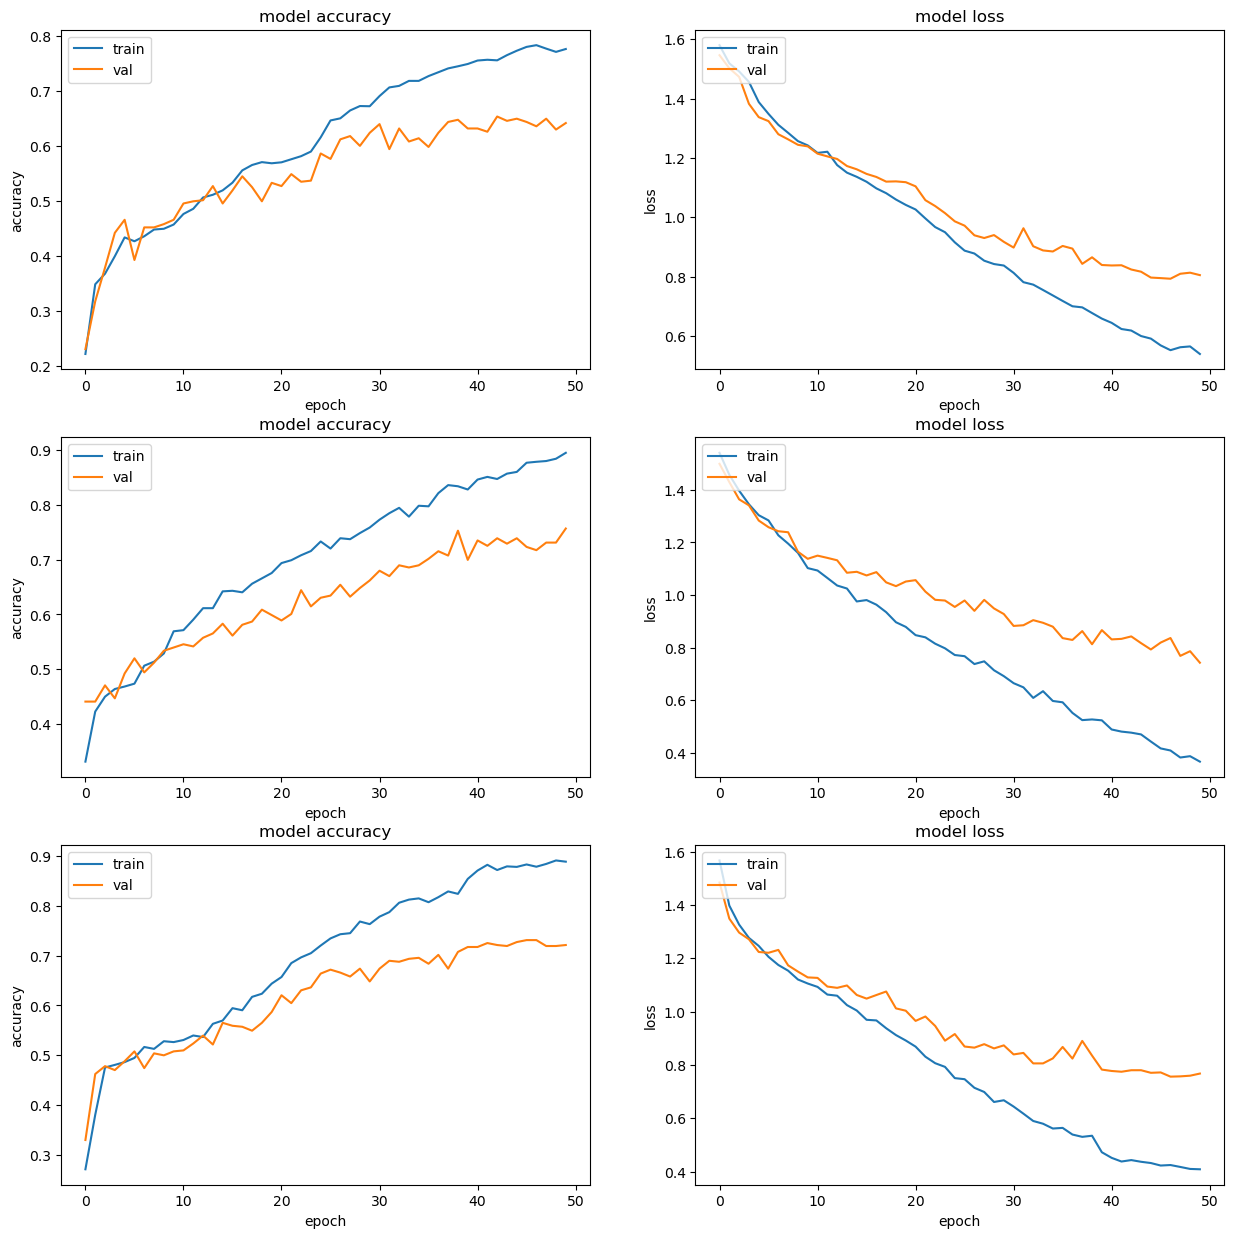

Epoch 1/50
90/90 [==============================] - 3s 19ms/step - loss: 1.5936 - accuracy: 0.2824 - val_loss: 1.5467 - val_accuracy: 0.2569
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5279 - accuracy: 0.3408 - val_loss: 1.4718 - val_accuracy: 0.4071
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4814 - accuracy: 0.4048 - val_loss: 1.4351 - val_accuracy: 0.4565
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4128 - accuracy: 0.4929 - val_loss: 1.3666 - val_accuracy: 0.5435
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3590 - accuracy: 0.5271 - val_loss: 1.3537 - val_accuracy: 0.5395
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3330 - accuracy: 0.5262 - val_loss: 1.3023 - val_accuracy: 0.5632
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3172 - accuracy: 0.5331 - val_loss: 1.2774 - val_accuracy: 0.5514
Epoch 8/50
90

90/90 [==============================] - 1s 15ms/step - loss: 1.1736 - accuracy: 0.5887 - val_loss: 1.2067 - val_accuracy: 0.5435
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1361 - accuracy: 0.5899 - val_loss: 1.1827 - val_accuracy: 0.5771
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1003 - accuracy: 0.6016 - val_loss: 1.1461 - val_accuracy: 0.5909
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0769 - accuracy: 0.6385 - val_loss: 1.1172 - val_accuracy: 0.5988
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0416 - accuracy: 0.6634 - val_loss: 1.1009 - val_accuracy: 0.6028
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9882 - accuracy: 0.6874 - val_loss: 1.0778 - val_accuracy: 0.6166
Epoch 14/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9673 - accuracy: 0.7087 - val_loss: 1.0974 - val_accuracy: 0.5968
Epoch 15/50
90/90 [

90/90 [==============================] - 1s 15ms/step - loss: 1.0678 - accuracy: 0.5536 - val_loss: 1.1026 - val_accuracy: 0.5593
Epoch 15/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0325 - accuracy: 0.6059 - val_loss: 1.1093 - val_accuracy: 0.5375
Epoch 16/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0167 - accuracy: 0.6314 - val_loss: 1.0627 - val_accuracy: 0.5731
Epoch 17/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9700 - accuracy: 0.6452 - val_loss: 1.0652 - val_accuracy: 0.5791
Epoch 18/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9396 - accuracy: 0.6677 - val_loss: 1.1523 - val_accuracy: 0.5751
Epoch 19/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9730 - accuracy: 0.6518 - val_loss: 1.0430 - val_accuracy: 0.5949
Epoch 20/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8818 - accuracy: 0.6816 - val_loss: 1.0479 - val_accuracy: 0.5870
Epoch 21/50
90/90 

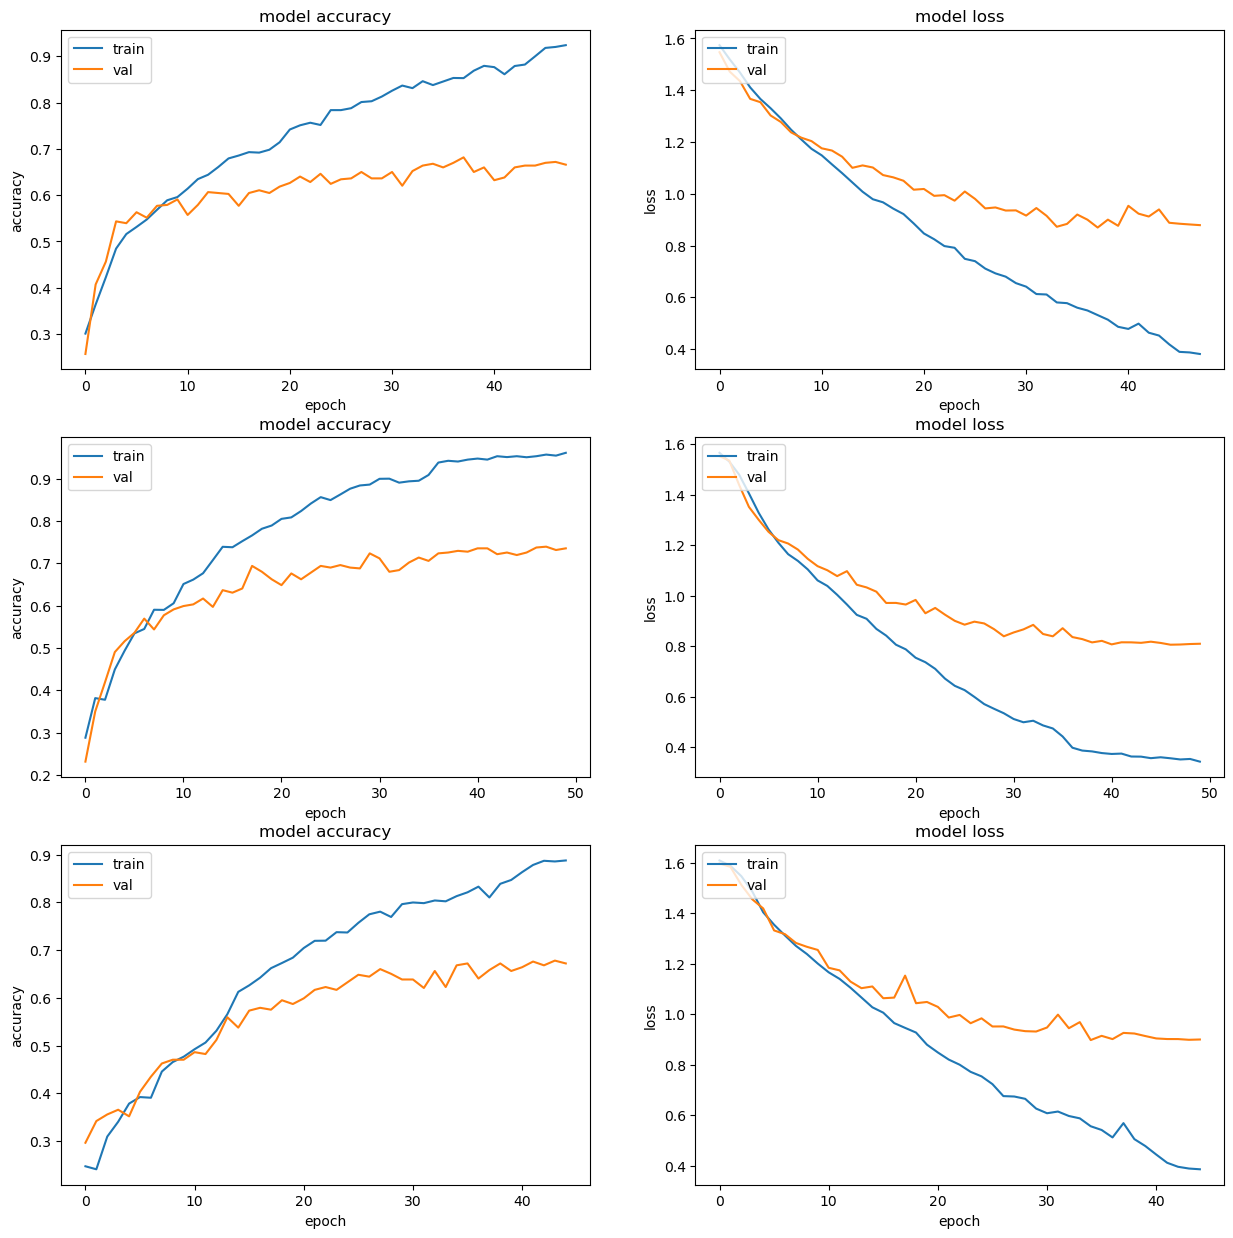

In [18]:
emovo2 = experiments(metadata, [data0s, data1s, data2s, data3s], y, get_m)

# RAVDESS

In [19]:
metadata, data0, data1, data2, data3, y = load_data('ravdess')
metadata

path     filename  chunk  \
0     /datasets/nicolas_facchinetti/emodb/data/14b09...  14b09Ac.wav      0   
1     /datasets/nicolas_facchinetti/emodb/data/14b09...  14b09Ac.wav      0   
2     /datasets/nicolas_facchinetti/emodb/data/14b09...  14b09Ac.wav      0   
3     /datasets/nicolas_facchinetti/emodb/data/14b09...  14b09Ac.wav      0   
4     /datasets/nicolas_facchinetti/emodb/data/14b09...  14b09Ac.wav      0   
...                                                 ...          ...    ...   
3740  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      0   
3741  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      1   
3742  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      0   
3743  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      0   
3744  /datasets/nicolas_facchinetti/emodb/data/08b01...  08b01Fe.wav      0   

      label  actor gender  mod  
0      fear     14      f    0  
1      fear     14      f    1  
2      fear     14      f    1  
3      fear     14      f    1  
4      fear     14      f    1  
...     ...    ...    ...  ...  
3740  happy      8      f    2  
3741  happy      8      f    2  
3742  happy      8      f    2  
3743  happy      8      f    2  
3744  happy      8      f    2  

[3745 rows x 7 columns]

In [20]:
data0.shape, data1.shape, data2.shape, data3.shape, y.shape

((3745, 261, 128, 1),
 (3745, 261, 128, 1),
 (3745, 261, 128, 1),
 (3745, 261, 128, 1),
 (3745, 5))

## Without standardization

Epoch 1/50
90/90 [==============================] - 3s 19ms/step - loss: 1.6126 - accuracy: 0.2323 - val_loss: 1.6065 - val_accuracy: 0.2352
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6034 - accuracy: 0.2326 - val_loss: 1.5337 - val_accuracy: 0.2352
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5459 - accuracy: 0.3343 - val_loss: 1.4982 - val_accuracy: 0.3893
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5115 - accuracy: 0.3814 - val_loss: 1.4813 - val_accuracy: 0.4150
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4598 - accuracy: 0.3769 - val_loss: 1.4161 - val_accuracy: 0.3953
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4235 - accuracy: 0.4028 - val_loss: 1.3814 - val_accuracy: 0.4605
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3802 - accuracy: 0.4565 - val_loss: 1.3439 - val_accuracy: 0.4644
Epoch 8/50
90

Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2121 - accuracy: 0.5531 - val_loss: 1.4157 - val_accuracy: 0.4071
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1763 - accuracy: 0.5298 - val_loss: 1.3203 - val_accuracy: 0.4071
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0829 - accuracy: 0.5968 - val_loss: 1.1098 - val_accuracy: 0.6067
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0232 - accuracy: 0.6270 - val_loss: 1.1438 - val_accuracy: 0.5593
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9803 - accuracy: 0.6349 - val_loss: 1.2426 - val_accuracy: 0.4921
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9765 - accuracy: 0.6298 - val_loss: 1.1048 - val_accuracy: 0.5395
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9048 - accuracy: 0.6658 - val_loss: 1.2336 - val_accuracy: 0.5040
Epoch 14/

Epoch 14/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9005 - accuracy: 0.6685 - val_loss: 1.0030 - val_accuracy: 0.5830
Epoch 15/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8731 - accuracy: 0.6740 - val_loss: 0.9632 - val_accuracy: 0.6146
Epoch 16/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8281 - accuracy: 0.6954 - val_loss: 1.0289 - val_accuracy: 0.5909
Epoch 17/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7955 - accuracy: 0.7125 - val_loss: 1.0924 - val_accuracy: 0.5455
Epoch 18/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7521 - accuracy: 0.7363 - val_loss: 1.0301 - val_accuracy: 0.6028
Epoch 19/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7200 - accuracy: 0.7551 - val_loss: 0.8364 - val_accuracy: 0.6759
Epoch 20/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7078 - accuracy: 0.7566 - val_loss: 0.9055 - val_accuracy: 0.6403
Epoch 

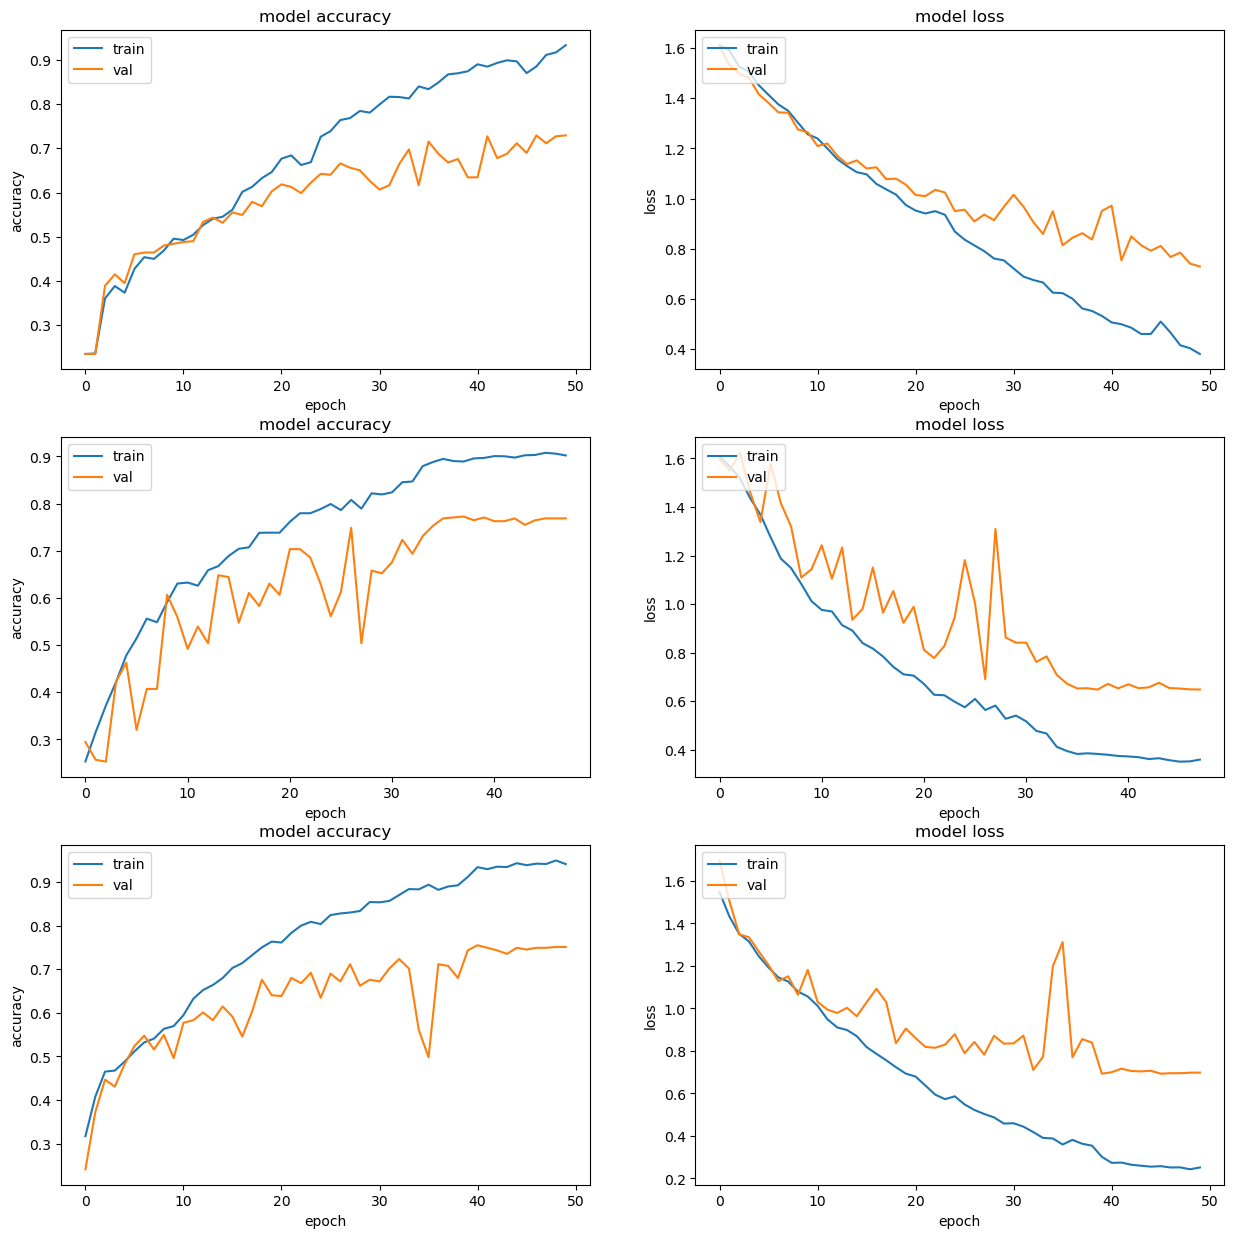

Epoch 1/50
90/90 [==============================] - 3s 19ms/step - loss: 1.6082 - accuracy: 0.2091 - val_loss: 1.6022 - val_accuracy: 0.2352
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6011 - accuracy: 0.2414 - val_loss: 1.6033 - val_accuracy: 0.2352
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6038 - accuracy: 0.2263 - val_loss: 1.6019 - val_accuracy: 0.2352
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6004 - accuracy: 0.2328 - val_loss: 1.6025 - val_accuracy: 0.2352
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6025 - accuracy: 0.2425 - val_loss: 1.6018 - val_accuracy: 0.2352
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6017 - accuracy: 0.2340 - val_loss: 1.6019 - val_accuracy: 0.2352
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6036 - accuracy: 0.2421 - val_loss: 1.6018 - val_accuracy: 0.2352
Epoch 8/50
90

90/90 [==============================] - 1s 15ms/step - loss: 1.4133 - accuracy: 0.4284 - val_loss: 1.9832 - val_accuracy: 0.2352
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3117 - accuracy: 0.4598 - val_loss: 2.0555 - val_accuracy: 0.2352
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3368 - accuracy: 0.4405 - val_loss: 1.3788 - val_accuracy: 0.3834
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2318 - accuracy: 0.4895 - val_loss: 1.7348 - val_accuracy: 0.2332
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2194 - accuracy: 0.4833 - val_loss: 2.1758 - val_accuracy: 0.2312
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1697 - accuracy: 0.5275 - val_loss: 2.2254 - val_accuracy: 0.2312
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1167 - accuracy: 0.5427 - val_loss: 1.8987 - val_accuracy: 0.1877
Epoch 13/50
90/90 [==

Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3269 - accuracy: 0.4572 - val_loss: 1.7100 - val_accuracy: 0.2451
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3056 - accuracy: 0.4468 - val_loss: 1.6324 - val_accuracy: 0.2352
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2561 - accuracy: 0.4682 - val_loss: 1.9291 - val_accuracy: 0.2372
Epoch 14/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2358 - accuracy: 0.4851 - val_loss: 1.6092 - val_accuracy: 0.2372
Epoch 15/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2134 - accuracy: 0.4903 - val_loss: 1.5903 - val_accuracy: 0.2490
Epoch 16/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1957 - accuracy: 0.4975 - val_loss: 1.6490 - val_accuracy: 0.2372

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 17/50
90/90 [==============================] - 1s 15ms/step 

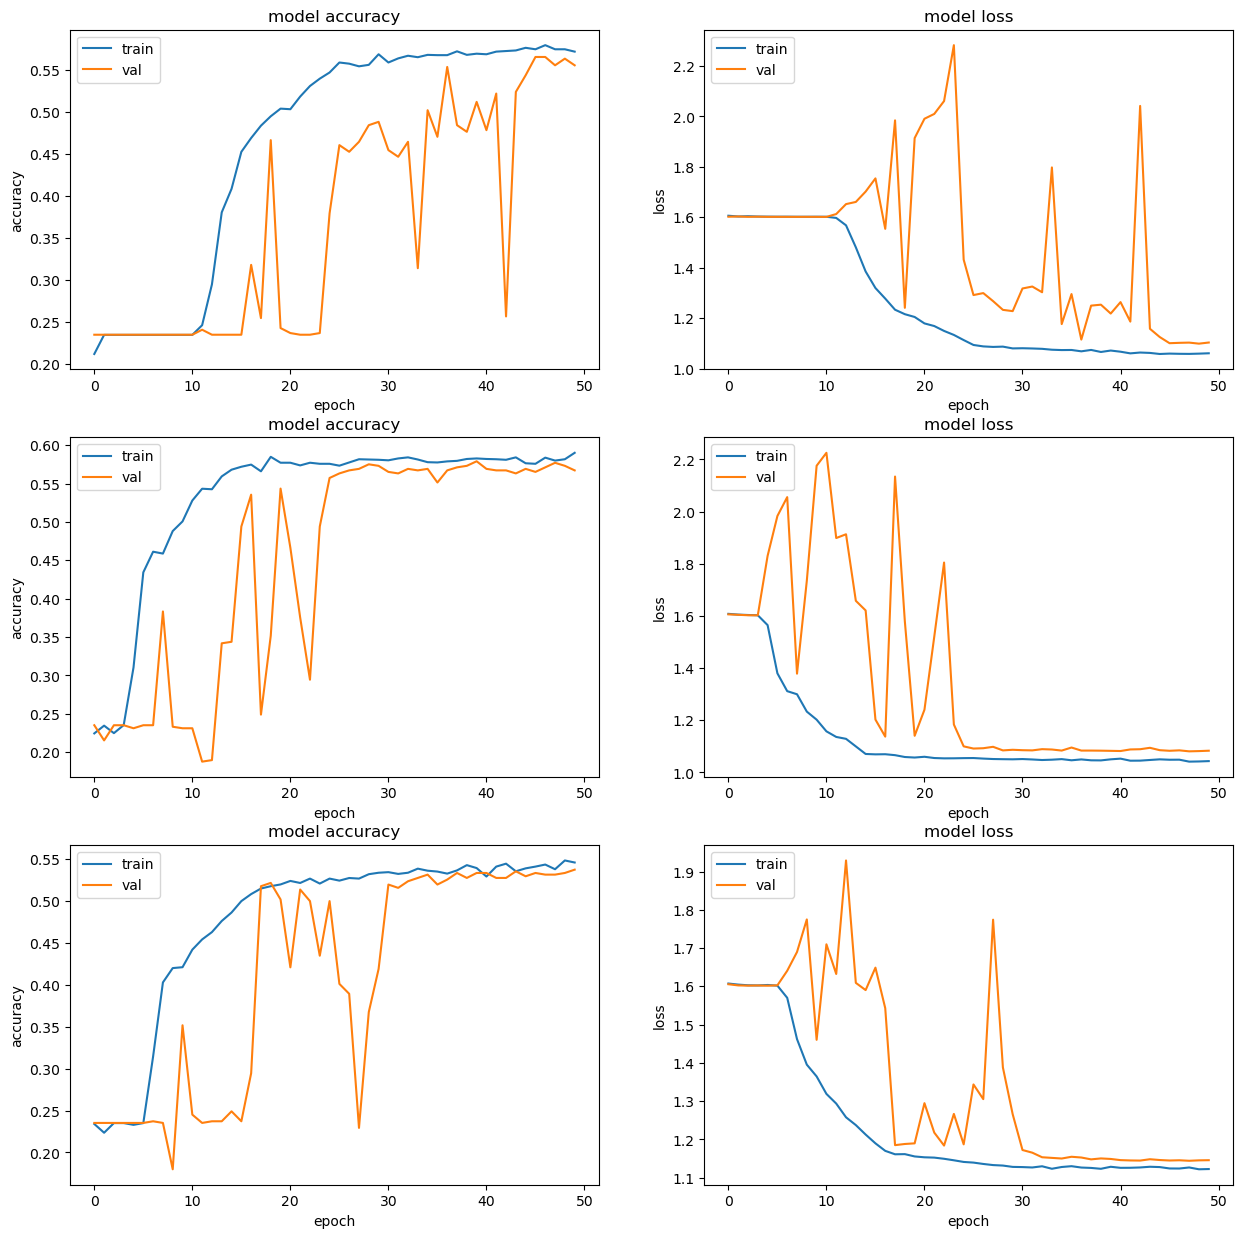

Epoch 1/50
90/90 [==============================] - 3s 19ms/step - loss: 1.5335 - accuracy: 0.2959 - val_loss: 1.5780 - val_accuracy: 0.3024
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4582 - accuracy: 0.3217 - val_loss: 1.5086 - val_accuracy: 0.4111
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3673 - accuracy: 0.3682 - val_loss: 1.4174 - val_accuracy: 0.3775
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2263 - accuracy: 0.4977 - val_loss: 1.2843 - val_accuracy: 0.4941
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1767 - accuracy: 0.5350 - val_loss: 1.2429 - val_accuracy: 0.5257
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1622 - accuracy: 0.5311 - val_loss: 1.1363 - val_accuracy: 0.5672
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1285 - accuracy: 0.5559 - val_loss: 1.1243 - val_accuracy: 0.5771
Epoch 8/50
90

Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0407 - accuracy: 0.6021 - val_loss: 1.0573 - val_accuracy: 0.5771
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9980 - accuracy: 0.6205 - val_loss: 1.0571 - val_accuracy: 0.5692
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9845 - accuracy: 0.6175 - val_loss: 1.2198 - val_accuracy: 0.5198
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9443 - accuracy: 0.6296 - val_loss: 1.2031 - val_accuracy: 0.5178
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8783 - accuracy: 0.6753 - val_loss: 0.9646 - val_accuracy: 0.6186
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8870 - accuracy: 0.6565 - val_loss: 1.1428 - val_accuracy: 0.5217
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8363 - accuracy: 0.6872 - val_loss: 0.9732 - val_accuracy: 0.6265
Epoch 14/

Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7994 - accuracy: 0.7153 - val_loss: 0.9453 - val_accuracy: 0.6443
Epoch 14/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7134 - accuracy: 0.7637 - val_loss: 1.0624 - val_accuracy: 0.6087
Epoch 15/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7057 - accuracy: 0.7711 - val_loss: 1.7411 - val_accuracy: 0.3735
Epoch 16/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7125 - accuracy: 0.7519 - val_loss: 0.8630 - val_accuracy: 0.6957
Epoch 17/50
90/90 [==============================] - 1s 15ms/step - loss: 0.6501 - accuracy: 0.7921 - val_loss: 0.8364 - val_accuracy: 0.6897
Epoch 18/50
90/90 [==============================] - 1s 15ms/step - loss: 0.6532 - accuracy: 0.7747 - val_loss: 0.7576 - val_accuracy: 0.7292
Epoch 19/50
90/90 [==============================] - 1s 15ms/step - loss: 0.5897 - accuracy: 0.8116 - val_loss: 0.8657 - val_accuracy: 0.6779
Epoch 

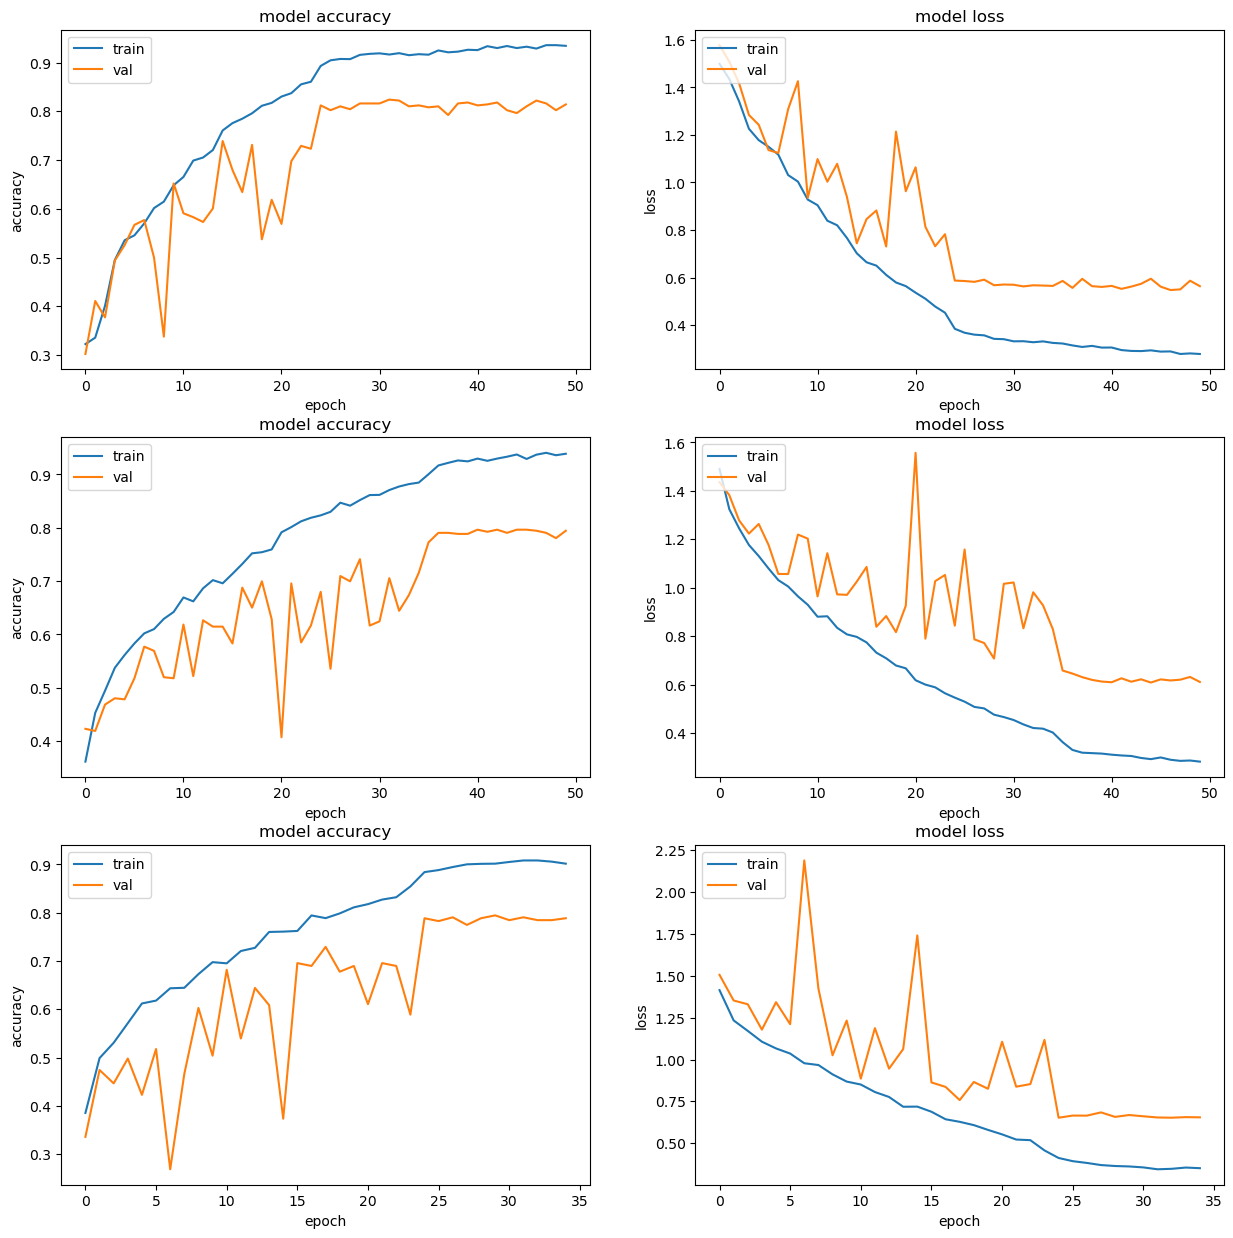

Epoch 1/50
90/90 [==============================] - 3s 19ms/step - loss: 1.6054 - accuracy: 0.2332 - val_loss: 1.6423 - val_accuracy: 0.2134
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5695 - accuracy: 0.3695 - val_loss: 1.6423 - val_accuracy: 0.2154
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5198 - accuracy: 0.4051 - val_loss: 1.6230 - val_accuracy: 0.2431
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4817 - accuracy: 0.4192 - val_loss: 1.5480 - val_accuracy: 0.3221
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4529 - accuracy: 0.4134 - val_loss: 1.5103 - val_accuracy: 0.3577
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3865 - accuracy: 0.4317 - val_loss: 1.3503 - val_accuracy: 0.4743
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3214 - accuracy: 0.4561 - val_loss: 1.2663 - val_accuracy: 0.5119
Epoch 8/50
90

90/90 [==============================] - 1s 15ms/step - loss: 0.6008 - accuracy: 0.8126 - val_loss: 0.8451 - val_accuracy: 0.7115
Epoch 24/50
90/90 [==============================] - 1s 15ms/step - loss: 0.5631 - accuracy: 0.8337 - val_loss: 0.8232 - val_accuracy: 0.7016
Epoch 25/50
90/90 [==============================] - 1s 15ms/step - loss: 0.5353 - accuracy: 0.8424 - val_loss: 0.8380 - val_accuracy: 0.7134
Epoch 26/50
90/90 [==============================] - 1s 15ms/step - loss: 0.5261 - accuracy: 0.8328 - val_loss: 0.7756 - val_accuracy: 0.7352
Epoch 27/50
90/90 [==============================] - 1s 15ms/step - loss: 0.4715 - accuracy: 0.8644 - val_loss: 0.7904 - val_accuracy: 0.7352
Epoch 28/50
90/90 [==============================] - 1s 15ms/step - loss: 0.4656 - accuracy: 0.8621 - val_loss: 0.7922 - val_accuracy: 0.7352
Epoch 29/50
90/90 [==============================] - 1s 15ms/step - loss: 0.4425 - accuracy: 0.8731 - val_loss: 0.8585 - val_accuracy: 0.7055
Epoch 30/50
90/90 

90/90 [==============================] - 1s 15ms/step - loss: 0.9722 - accuracy: 0.6636 - val_loss: 1.2099 - val_accuracy: 0.4941
Epoch 29/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9062 - accuracy: 0.6783 - val_loss: 1.1906 - val_accuracy: 0.4921
Epoch 30/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8720 - accuracy: 0.7024 - val_loss: 1.2076 - val_accuracy: 0.4921
Epoch 31/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8516 - accuracy: 0.6951 - val_loss: 1.1684 - val_accuracy: 0.5158
Epoch 32/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8143 - accuracy: 0.7171 - val_loss: 1.1643 - val_accuracy: 0.5178
Epoch 33/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7664 - accuracy: 0.7713 - val_loss: 1.1308 - val_accuracy: 0.5632
Epoch 34/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7478 - accuracy: 0.7801 - val_loss: 1.1714 - val_accuracy: 0.5375
Epoch 35/50
90/90 

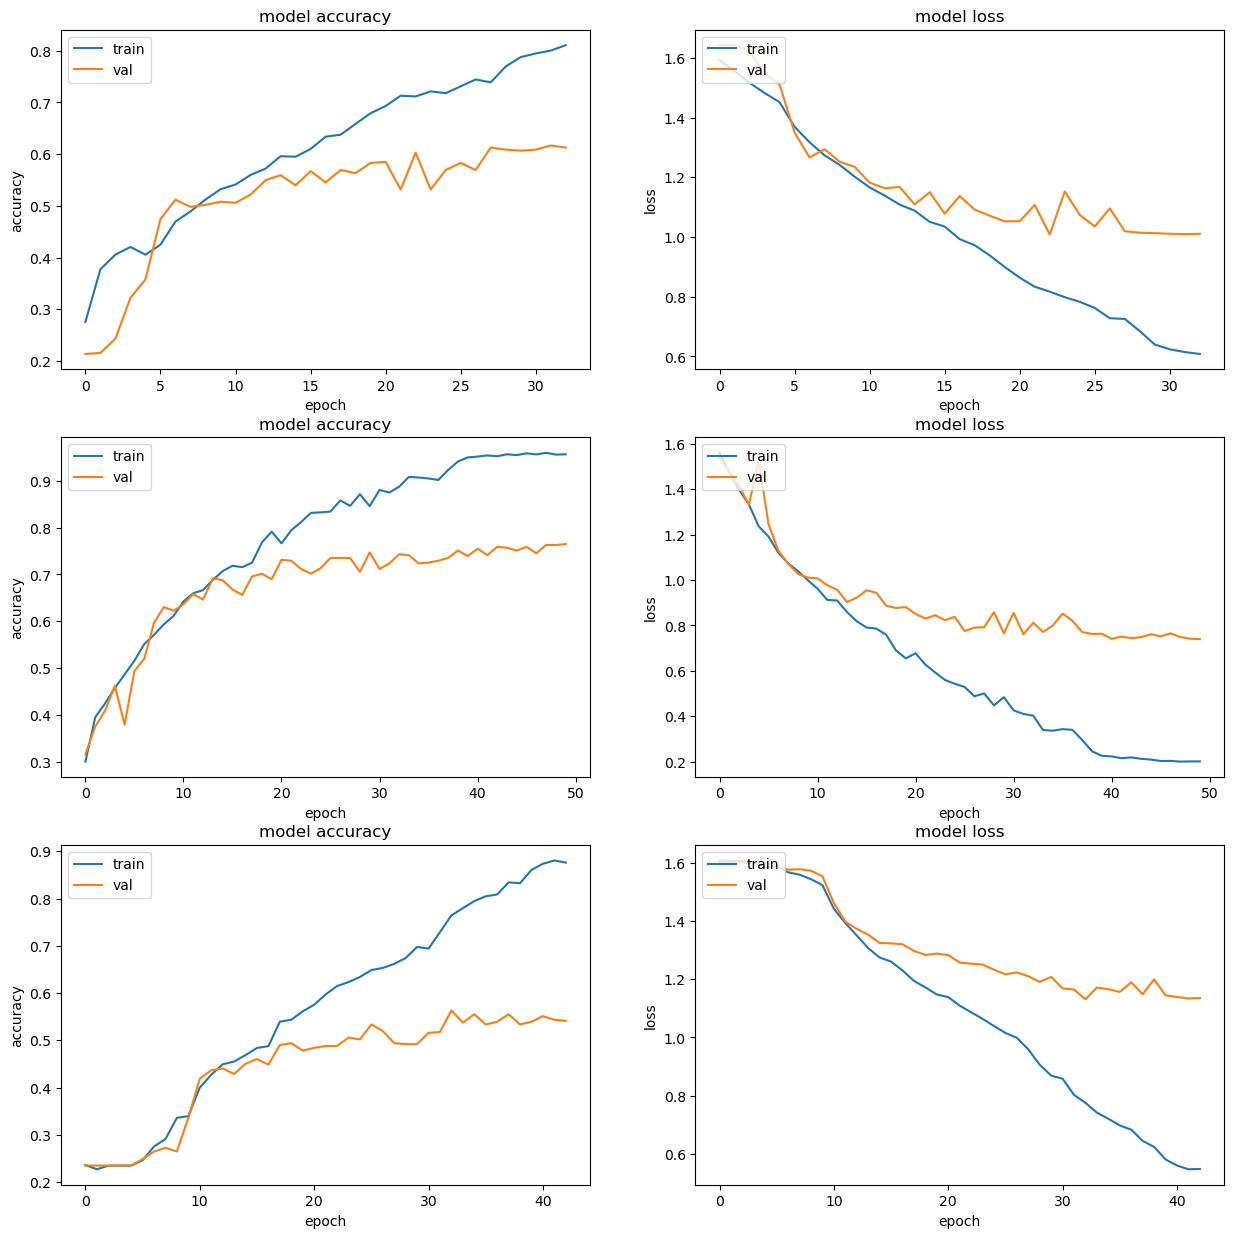

In [21]:
ravdess1 = experiments(metadata, [data0, data1, data2, data3], y, get_m)

## With standardization

In [22]:
data0s = standardize(data0)
data1s = standardize(data1)
data2s = standardize(data2)
data3s = standardize(data3)

Epoch 1/50
90/90 [==============================] - 3s 19ms/step - loss: 1.5457 - accuracy: 0.3174 - val_loss: 1.4768 - val_accuracy: 0.3893
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4376 - accuracy: 0.4039 - val_loss: 1.3901 - val_accuracy: 0.4289
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3729 - accuracy: 0.4308 - val_loss: 1.3767 - val_accuracy: 0.4249
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3750 - accuracy: 0.4068 - val_loss: 1.3312 - val_accuracy: 0.4466
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3339 - accuracy: 0.4347 - val_loss: 1.3081 - val_accuracy: 0.4348
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3142 - accuracy: 0.4332 - val_loss: 1.3062 - val_accuracy: 0.4407
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2997 - accuracy: 0.4399 - val_loss: 1.2797 - val_accuracy: 0.4387
Epoch 8/50
90

90/90 [==============================] - 1s 15ms/step - loss: 1.1668 - accuracy: 0.5491 - val_loss: 1.1837 - val_accuracy: 0.5237
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1301 - accuracy: 0.5542 - val_loss: 1.1338 - val_accuracy: 0.5613
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1054 - accuracy: 0.5546 - val_loss: 1.1110 - val_accuracy: 0.6028
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0749 - accuracy: 0.5738 - val_loss: 1.1095 - val_accuracy: 0.5909
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0390 - accuracy: 0.6066 - val_loss: 1.1209 - val_accuracy: 0.5316
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0048 - accuracy: 0.6160 - val_loss: 1.0636 - val_accuracy: 0.5889
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9795 - accuracy: 0.6320 - val_loss: 1.0214 - val_accuracy: 0.6206
Epoch 14/50
90/90 [=

90/90 [==============================] - 1s 15ms/step - loss: 1.0763 - accuracy: 0.5796 - val_loss: 1.1008 - val_accuracy: 0.5395
Epoch 14/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0610 - accuracy: 0.5751 - val_loss: 1.0898 - val_accuracy: 0.5771
Epoch 15/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0360 - accuracy: 0.6086 - val_loss: 1.0905 - val_accuracy: 0.5494
Epoch 16/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9905 - accuracy: 0.6266 - val_loss: 1.0771 - val_accuracy: 0.5771
Epoch 17/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9711 - accuracy: 0.6333 - val_loss: 1.0545 - val_accuracy: 0.5751
Epoch 18/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9500 - accuracy: 0.6440 - val_loss: 1.0589 - val_accuracy: 0.5613
Epoch 19/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9453 - accuracy: 0.6263 - val_loss: 1.0108 - val_accuracy: 0.5909
Epoch 20/50
90/90 

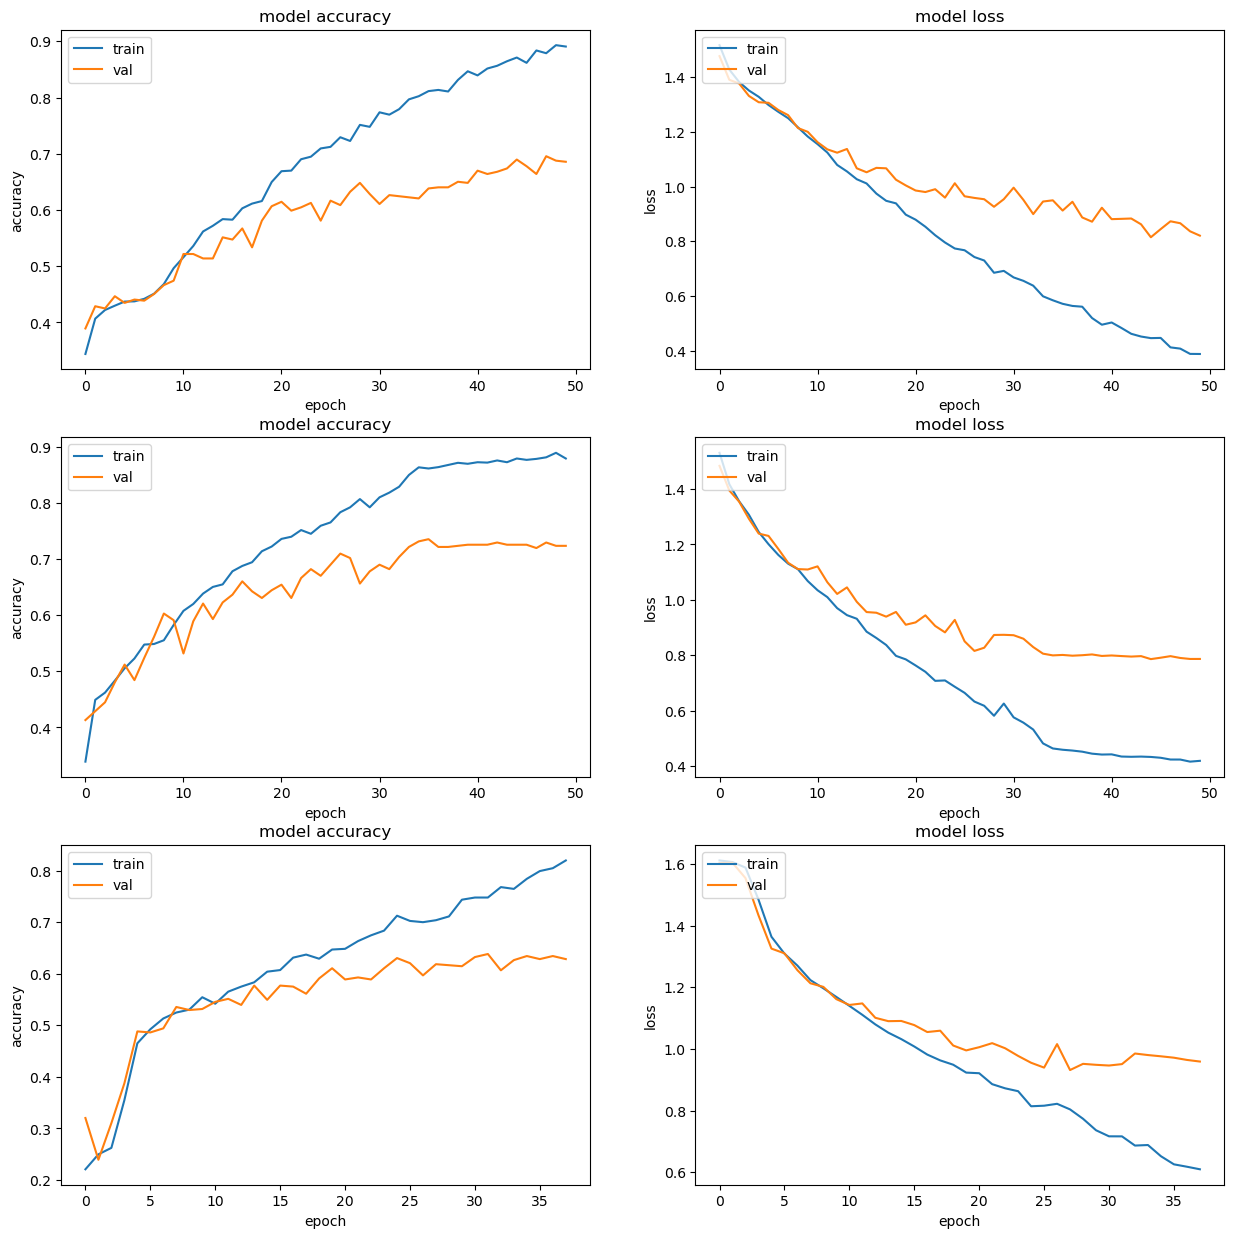

Epoch 1/50
90/90 [==============================] - 4s 19ms/step - loss: 1.6125 - accuracy: 0.2086 - val_loss: 1.5483 - val_accuracy: 0.2609
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5393 - accuracy: 0.3127 - val_loss: 1.5081 - val_accuracy: 0.2925
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4759 - accuracy: 0.3883 - val_loss: 1.4205 - val_accuracy: 0.4447
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4668 - accuracy: 0.4174 - val_loss: 1.3896 - val_accuracy: 0.4625
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4104 - accuracy: 0.4421 - val_loss: 1.3371 - val_accuracy: 0.4941
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3522 - accuracy: 0.4878 - val_loss: 1.3082 - val_accuracy: 0.5336
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3019 - accuracy: 0.5018 - val_loss: 1.2705 - val_accuracy: 0.5435
Epoch 8/50
90

90/90 [==============================] - 1s 15ms/step - loss: 1.2997 - accuracy: 0.5072 - val_loss: 1.3033 - val_accuracy: 0.4802
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2385 - accuracy: 0.5138 - val_loss: 1.1943 - val_accuracy: 0.5553
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1932 - accuracy: 0.5338 - val_loss: 1.1675 - val_accuracy: 0.5553
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1117 - accuracy: 0.5733 - val_loss: 1.1016 - val_accuracy: 0.5731
Epoch 10/50
90/90 [==============================] - 1s 14ms/step - loss: 1.0556 - accuracy: 0.5916 - val_loss: 1.0934 - val_accuracy: 0.5751
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0291 - accuracy: 0.5955 - val_loss: 1.0453 - val_accuracy: 0.5949
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 0.9719 - accuracy: 0.6230 - val_loss: 1.0458 - val_accuracy: 0.5929
Epoch 13/50
90/90 [==

90/90 [==============================] - 1s 15ms/step - loss: 0.8931 - accuracy: 0.6784 - val_loss: 1.0246 - val_accuracy: 0.5850
Epoch 20/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8546 - accuracy: 0.6886 - val_loss: 1.0082 - val_accuracy: 0.6067
Epoch 21/50
90/90 [==============================] - 1s 15ms/step - loss: 0.8204 - accuracy: 0.7124 - val_loss: 0.9564 - val_accuracy: 0.6304
Epoch 22/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7581 - accuracy: 0.7560 - val_loss: 0.9428 - val_accuracy: 0.6403
Epoch 23/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7195 - accuracy: 0.7814 - val_loss: 0.9770 - val_accuracy: 0.6206
Epoch 24/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7310 - accuracy: 0.7547 - val_loss: 0.9267 - val_accuracy: 0.6542
Epoch 25/50
90/90 [==============================] - 1s 15ms/step - loss: 0.7072 - accuracy: 0.7652 - val_loss: 0.9151 - val_accuracy: 0.6423
Epoch 26/50
90/90 

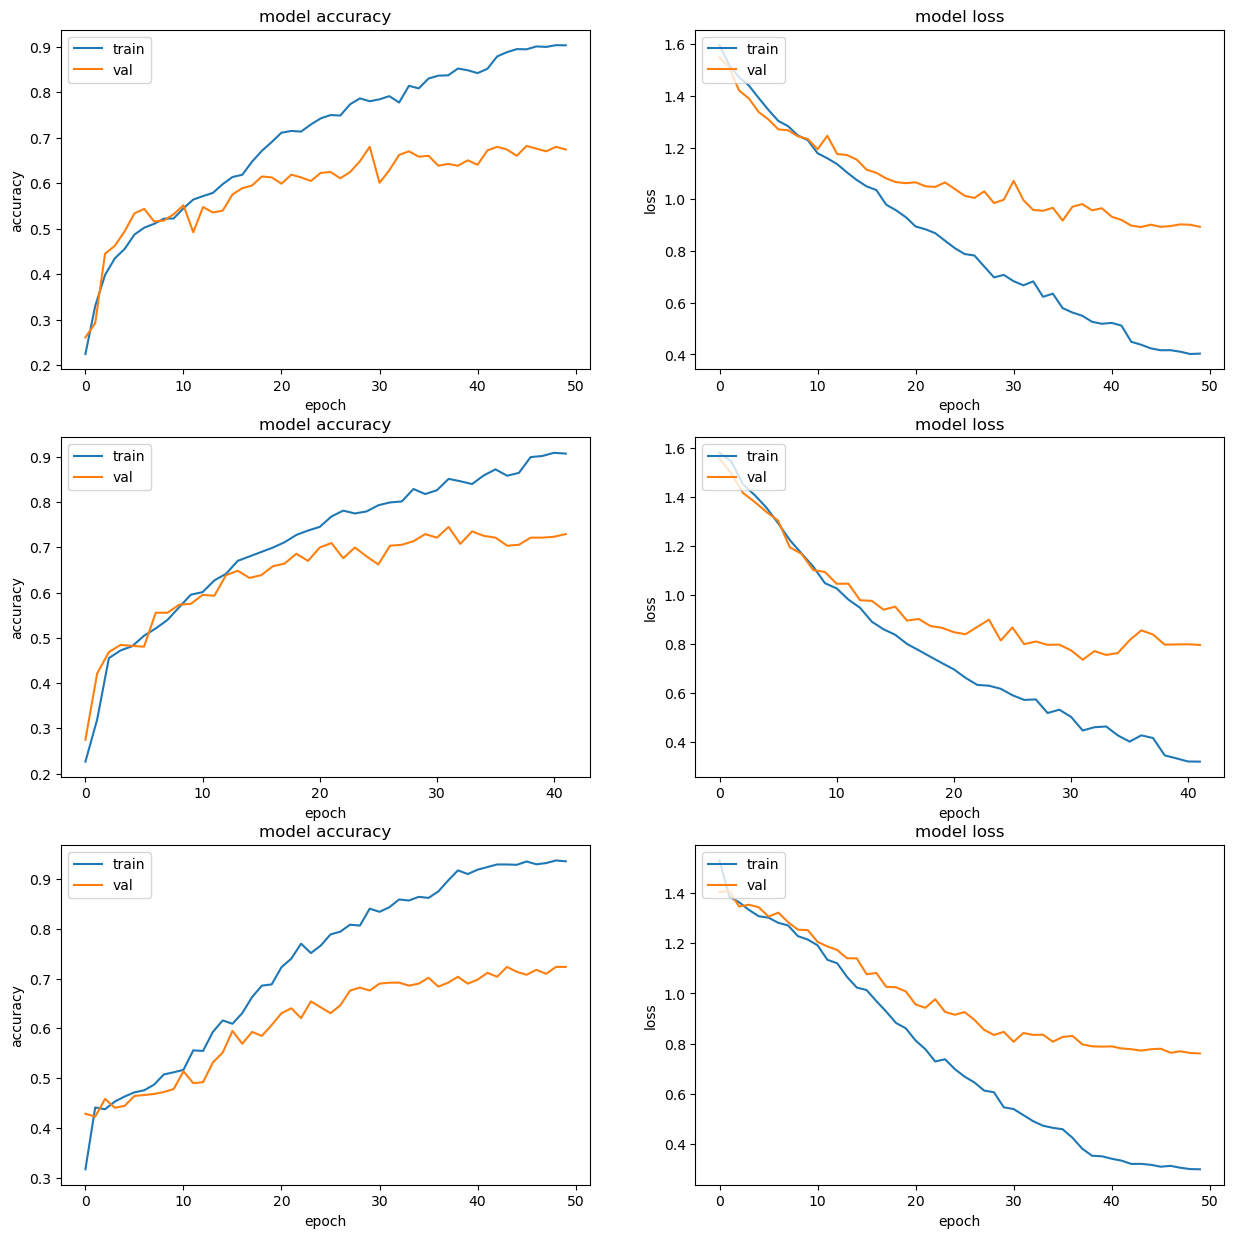

Epoch 1/50
90/90 [==============================] - 3s 18ms/step - loss: 1.6000 - accuracy: 0.2349 - val_loss: 1.5244 - val_accuracy: 0.3241
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5253 - accuracy: 0.3996 - val_loss: 1.5261 - val_accuracy: 0.3123
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4877 - accuracy: 0.4157 - val_loss: 1.4560 - val_accuracy: 0.4763
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4395 - accuracy: 0.4520 - val_loss: 1.4467 - val_accuracy: 0.4466
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4122 - accuracy: 0.4748 - val_loss: 1.4032 - val_accuracy: 0.4565
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3689 - accuracy: 0.4828 - val_loss: 1.3790 - val_accuracy: 0.4842
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3448 - accuracy: 0.5079 - val_loss: 1.3178 - val_accuracy: 0.5000
Epoch 8/50
90

90/90 [==============================] - 1s 15ms/step - loss: 1.3325 - accuracy: 0.4495 - val_loss: 1.3473 - val_accuracy: 0.4506
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2748 - accuracy: 0.4816 - val_loss: 1.3103 - val_accuracy: 0.4783
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2500 - accuracy: 0.4961 - val_loss: 1.2603 - val_accuracy: 0.4921
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2083 - accuracy: 0.5213 - val_loss: 1.2334 - val_accuracy: 0.4862
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1751 - accuracy: 0.5399 - val_loss: 1.2461 - val_accuracy: 0.4960
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1367 - accuracy: 0.5719 - val_loss: 1.2458 - val_accuracy: 0.4802
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1706 - accuracy: 0.5468 - val_loss: 1.1909 - val_accuracy: 0.5099
Epoch 14/50
90/90 [=

90/90 [==============================] - 1s 15ms/step - loss: 1.2140 - accuracy: 0.5132 - val_loss: 1.2461 - val_accuracy: 0.4704
Epoch 14/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1849 - accuracy: 0.5240 - val_loss: 1.2136 - val_accuracy: 0.4960
Epoch 15/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1671 - accuracy: 0.5337 - val_loss: 1.2472 - val_accuracy: 0.4625
Epoch 16/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1408 - accuracy: 0.5466 - val_loss: 1.2044 - val_accuracy: 0.5198
Epoch 17/50
90/90 [==============================] - 1s 15ms/step - loss: 1.1124 - accuracy: 0.5500 - val_loss: 1.1723 - val_accuracy: 0.5099
Epoch 18/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0828 - accuracy: 0.5722 - val_loss: 1.1437 - val_accuracy: 0.5395
Epoch 19/50
90/90 [==============================] - 1s 15ms/step - loss: 1.0513 - accuracy: 0.5921 - val_loss: 1.1320 - val_accuracy: 0.5692
Epoch 20/50
90/90 

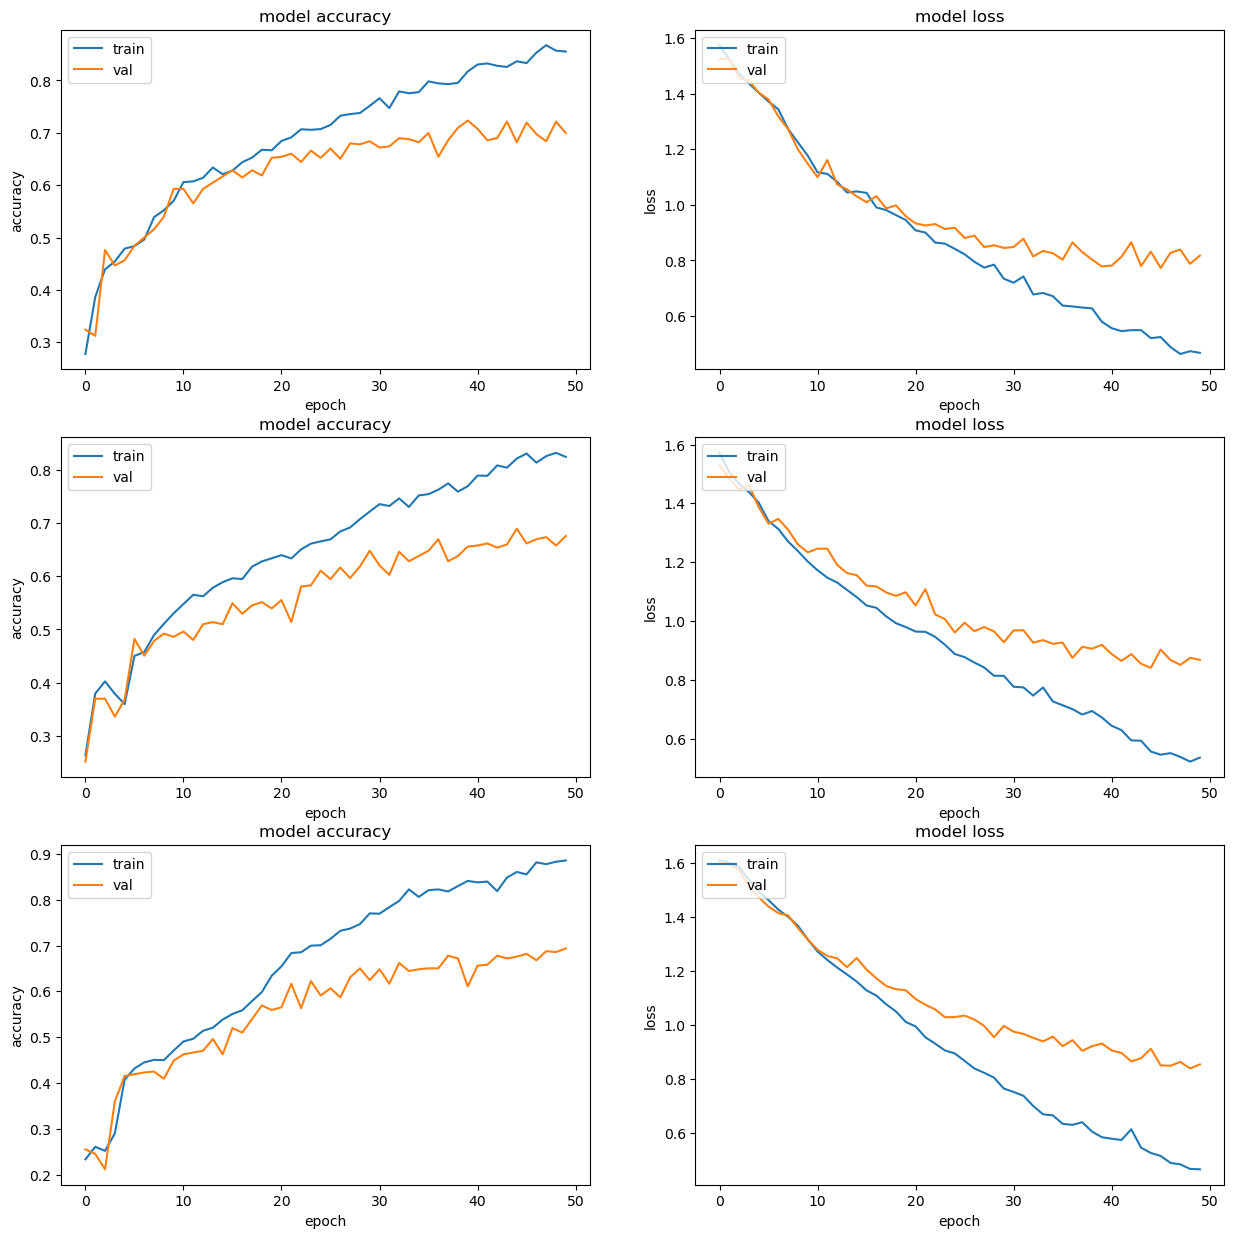

Epoch 1/50
90/90 [==============================] - 3s 19ms/step - loss: 1.6230 - accuracy: 0.2048 - val_loss: 1.6042 - val_accuracy: 0.2826
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6060 - accuracy: 0.2377 - val_loss: 1.5807 - val_accuracy: 0.2708
Epoch 3/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5955 - accuracy: 0.2709 - val_loss: 1.4591 - val_accuracy: 0.4625
Epoch 4/50
90/90 [==============================] - 1s 15ms/step - loss: 1.4485 - accuracy: 0.4169 - val_loss: 1.3537 - val_accuracy: 0.4960
Epoch 5/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3722 - accuracy: 0.4567 - val_loss: 1.3165 - val_accuracy: 0.4684
Epoch 6/50
90/90 [==============================] - 1s 15ms/step - loss: 1.3267 - accuracy: 0.4733 - val_loss: 1.2847 - val_accuracy: 0.4684
Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.2689 - accuracy: 0.4936 - val_loss: 1.1955 - val_accuracy: 0.5040
Epoch 8/50
90

Epoch 7/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6226 - accuracy: 0.2122 - val_loss: 1.6082 - val_accuracy: 0.2154
Epoch 8/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6075 - accuracy: 0.2116 - val_loss: 1.6036 - val_accuracy: 0.2154
Epoch 9/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6009 - accuracy: 0.2416 - val_loss: 1.6024 - val_accuracy: 0.2352
Epoch 10/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6040 - accuracy: 0.2381 - val_loss: 1.6020 - val_accuracy: 0.2352
Epoch 11/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5960 - accuracy: 0.2315 - val_loss: 1.6019 - val_accuracy: 0.2352
Epoch 12/50
90/90 [==============================] - 1s 15ms/step - loss: 1.5967 - accuracy: 0.2529 - val_loss: 1.6018 - val_accuracy: 0.2352
Epoch 13/50
90/90 [==============================] - 1s 15ms/step - loss: 1.6026 - accuracy: 0.2319 - val_loss: 1.6018 - val_accuracy: 0.2352
Epoch 14/

Epoch 35/50
90/90 [==============================] - 1s 15ms/step - loss: 0.5397 - accuracy: 0.8263 - val_loss: 0.8245 - val_accuracy: 0.6818
Epoch 36/50
90/90 [==============================] - 1s 15ms/step - loss: 0.5569 - accuracy: 0.8195 - val_loss: 0.8900 - val_accuracy: 0.6581
Epoch 37/50
90/90 [==============================] - 1s 15ms/step - loss: 0.5300 - accuracy: 0.8359 - val_loss: 0.8649 - val_accuracy: 0.6798
Epoch 38/50
90/90 [==============================] - 1s 15ms/step - loss: 0.5159 - accuracy: 0.8433 - val_loss: 0.8244 - val_accuracy: 0.6838
Epoch 39/50
90/90 [==============================] - 1s 15ms/step - loss: 0.4786 - accuracy: 0.8634 - val_loss: 0.8646 - val_accuracy: 0.6779
Epoch 40/50
90/90 [==============================] - 1s 15ms/step - loss: 0.4875 - accuracy: 0.8656 - val_loss: 0.8772 - val_accuracy: 0.6680
Epoch 41/50
90/90 [==============================] - 1s 15ms/step - loss: 0.4461 - accuracy: 0.8852 - val_loss: 0.8449 - val_accuracy: 0.6838

Epoch

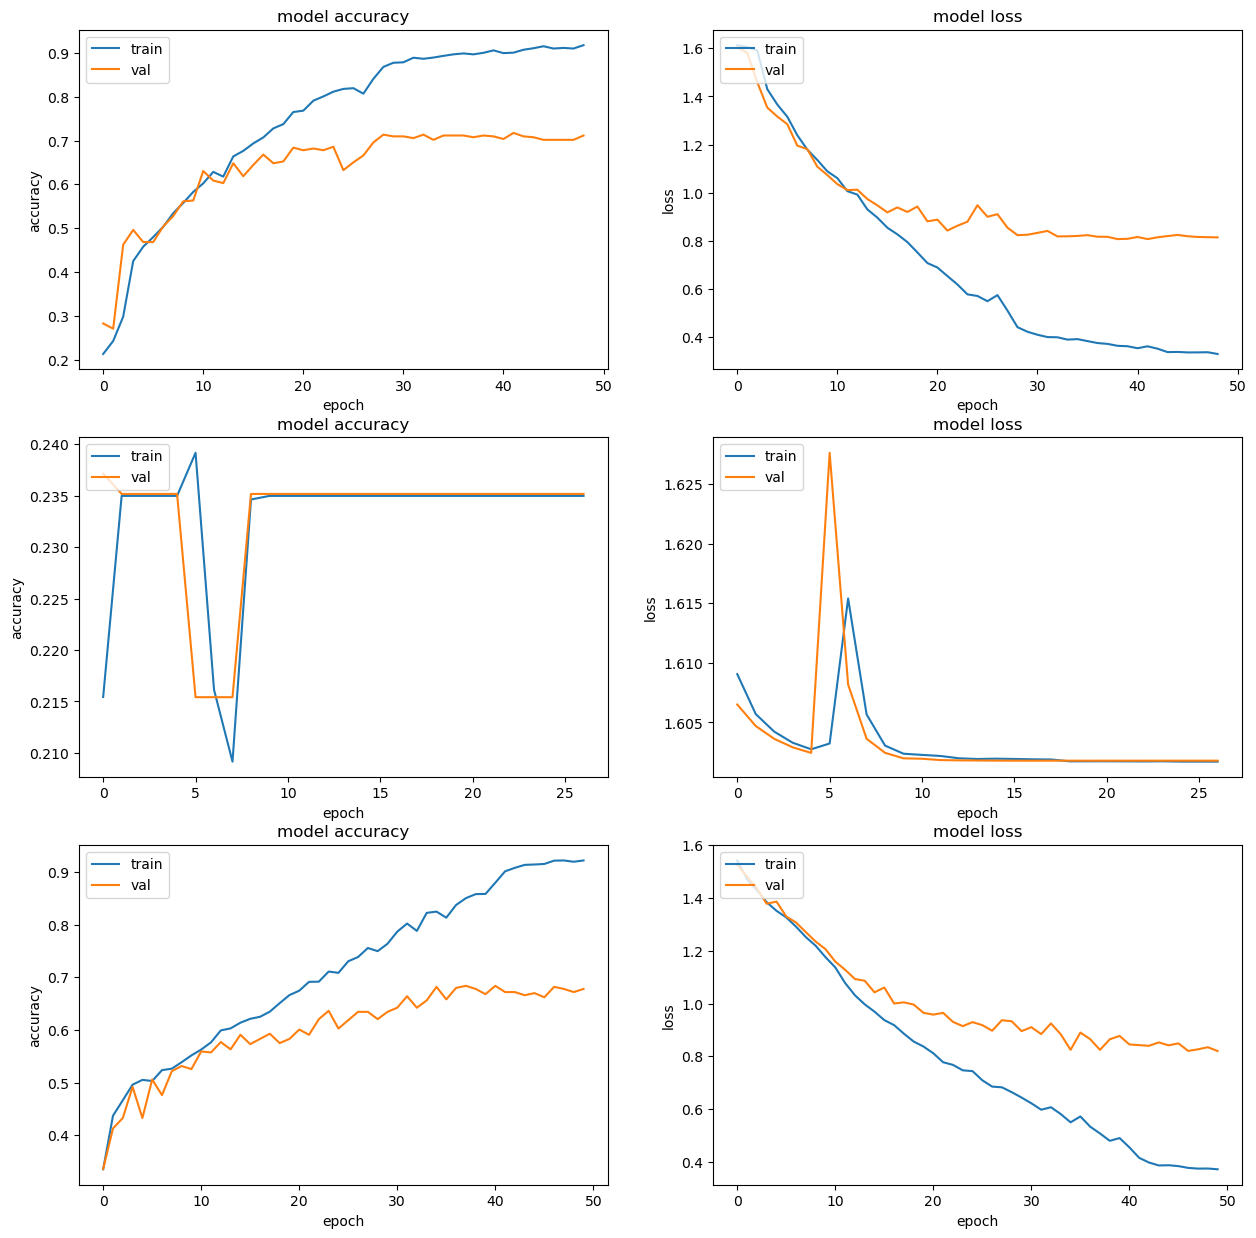

In [23]:
ravdess2 = experiments(metadata, [data0s, data1s, data2s, data3s], y, get_m)

# Results comparison

In [24]:
def get_mean_acc(p):
    acc = [[test[1][1] for test in exp ] for exp in p]
    return np.asarray([np.mean(exp) for exp in acc])

In [25]:
get_mean_acc(emodb1)

array([0.66488888, 0.56533333, 0.61866667, 0.71733334])

In [26]:
get_mean_acc(emodb2)

array([0.64444445, 0.68355554, 0.47644443, 0.71111111])

In [27]:
np.concatenate((get_mean_acc(emodb1), get_mean_acc(emodb2)))

array([0.66488888, 0.56533333, 0.61866667, 0.71733334, 0.64444445,
       0.68355554, 0.47644443, 0.71111111])

In [28]:
index = ['original', 'norm1', 'norm2', 'norm3', 'original std', 'norm1 std', 'norm2 std', 'norm3 std']

In [30]:
union = pd.concat([pd.DataFrame(np.concatenate((get_mean_acc(emodb1), get_mean_acc(emodb2))), columns=['emodb'], index=index),
                   pd.DataFrame(np.concatenate((get_mean_acc(emovo1), get_mean_acc(emovo2))), columns=['emovo'], index=index),
                   pd.DataFrame(np.concatenate((get_mean_acc(ravdess1), get_mean_acc(ravdess2))), columns=['ravdess'], index=index)
                  ], axis=1)

In [31]:
union['mean'] = union.mean(axis=1)

In [32]:
union

emodb     emovo   ravdess      mean
original      0.664889  0.741333  0.737778  0.714667
norm1         0.565333  0.560000  0.553778  0.559704
norm2         0.618667  0.747556  0.784000  0.716741
norm3         0.717333  0.712889  0.640000  0.690074
original std  0.644444  0.620444  0.696000  0.653630
norm1 std     0.683556  0.655111  0.704889  0.681185
norm2 std     0.476444  0.696000  0.672000  0.614815
norm3 std     0.711111  0.670222  0.539556  0.640296